# Bluetooth DoS Classifier

This experiment looks to investigate the performance of a model that is not an Ensemble, K-nearest neighbor and Support Vector Classifier were tested but subsequently dropped as they had poor accuracy and very long testing and training time respectively. Will look to implement a linear regression classifier

***Findings***
- Baseline test with balanced weights and 1000 iterations 3m training time and  0.7541 accuracy
- 2nd test with balanced weights and 5000 iterations 5m training time and  0.70284 accuracy potential overfit?
- 3rd test set C to 0.1 with 1000 iterations 1.3m training time and 0.8323 accuracy and no increased performance with 5000 iterations. 
- 4th test using the saga solver with 




## Setup

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots as _
import seaborn as sns
import sklearn.metrics as metrics
from joblib import dump, load
from scipy.sparse import csr_matrix, hstack, load_npz, save_npz
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from wordcloud import WordCloud
plt.rcParams['text.usetex'] = False

In [2]:
DATA = os.path.abspath("../data")
MODELS = os.path.abspath("../models")

# data paths
ATTACK_TRAIN = os.path.join(DATA, "dos_train.csv")
BENIGN_TRAIN = os.path.join(DATA, "benign_train.csv")
ATTACK_TEST = os.path.join(DATA, "dos_test.csv")
BENIGN_TEST = os.path.join(DATA, "benign_test.csv")
CAPTURED_DATA = os.path.join(DATA, "capture.csv")

# preprocessed data paths
PREPROCESSED_TRAIN = os.path.join(DATA, "preprocessed_train.csv")
PREPROCESSED_TEST = os.path.join(DATA, "preprocessed_test.csv")
LABELS_TRAIN = os.path.join(DATA, f"labels_train.npy")
LABELS_TEST = os.path.join(DATA, f"labels_test.npy")

# features paths
FEATURES_TEST = os.path.join(DATA, f"features_test.npz")
FEATURES_TRAIN = os.path.join(DATA, f"features_train.npz")

# models paths
VECTORIZER_MODEL = os.path.join(MODELS, f"vectorizer.joblib")
ENCODER_MODEL = os.path.join(MODELS, f"encoder.joblib")
SCALER_MODEL = os.path.join(MODELS, f"scaler.joblib")
HASHER_MODEL = os.path.join(MODELS, f"hasher.joblib")
GBM_MODEL = os.path.join(MODELS, f"gbm.joblib")  # gradient boosting machine
LR_MODEL = os.path.join(MODELS, f"lr.joblib")  # Liner regression with class weights 

In [3]:
print("Data directory:", DATA)
print("Models directory:", MODELS)

# check that data files exist
data_paths = [ATTACK_TRAIN, BENIGN_TRAIN, ATTACK_TEST, BENIGN_TEST]
if not all(map(os.path.exists, data_paths)):
    raise Exception("Data files not found")

# create directories if they don't exist
if not os.path.exists(MODELS):
    os.makedirs("models")

# format plots
plt.style.use(["science", "ieee"])

Data directory: c:\RIT\Fifth_Year\CMPE-677\bluetooth-dos-classifier\data
Models directory: c:\RIT\Fifth_Year\CMPE-677\bluetooth-dos-classifier\models


## Dataset Processing

In [4]:
# read datasets
attack_train = pd.read_csv(ATTACK_TRAIN)
benign_train = pd.read_csv(BENIGN_TRAIN)
attack_test = pd.read_csv(ATTACK_TEST)
benign_test = pd.read_csv(BENIGN_TEST)
capture = pd.read_csv(CAPTURED_DATA)

In [5]:
# split captured data (80/20 split) and append to benign data
split_index = int(len(capture) * 0.8)  # required to preserve order
capture_train = capture.iloc[:split_index]
capture_test = capture.iloc[split_index:]
benign_train = pd.concat([benign_train, capture_train], ignore_index=True)
benign_test = pd.concat([benign_test, capture_test], ignore_index=True)

# add type column indicating attack or benign
attack_train["Type"] = 1
attack_test["Type"] = 1
benign_train["Type"] = 0
benign_test["Type"] = 0

# combine datasets
train_dataset = pd.concat([attack_train, benign_train], ignore_index=True)
test_dataset = pd.concat([attack_test, benign_test], ignore_index=True)

# generate labels
train_labels = train_dataset["Type"]
train_dataset.drop(columns=["Type"], inplace=True)
test_labels = test_dataset["Type"]
test_dataset.drop(columns=["Type"], inplace=True)

In [6]:
# write preprocessed dataset to files
train_dataset.to_csv(PREPROCESSED_TRAIN, index=False)
test_dataset.to_csv(PREPROCESSED_TEST, index=False)
np.save(LABELS_TRAIN, train_labels)
np.save(LABELS_TEST, test_labels)

Training and Testing dataset statistics:
                No.          Time        Length          Type
count  2.533706e+06  2.533706e+06  2.533706e+06  2.533706e+06
mean   4.170342e+05  1.993675e+05  6.519739e+01  4.933876e-01
std    3.039178e+05  3.693308e+05  1.507927e+02  4.999564e-01
min    1.000000e+00  0.000000e+00  3.000000e+00  0.000000e+00
25%    1.420250e+05  1.257302e+03  8.000000e+00  0.000000e+00
50%    3.661615e+05  3.491526e+03  1.900000e+01  0.000000e+00
75%    6.828748e+05  9.224927e+04  3.200000e+01  1.000000e+00
max    1.000784e+06  1.198804e+06  1.021000e+03  1.000000e+00



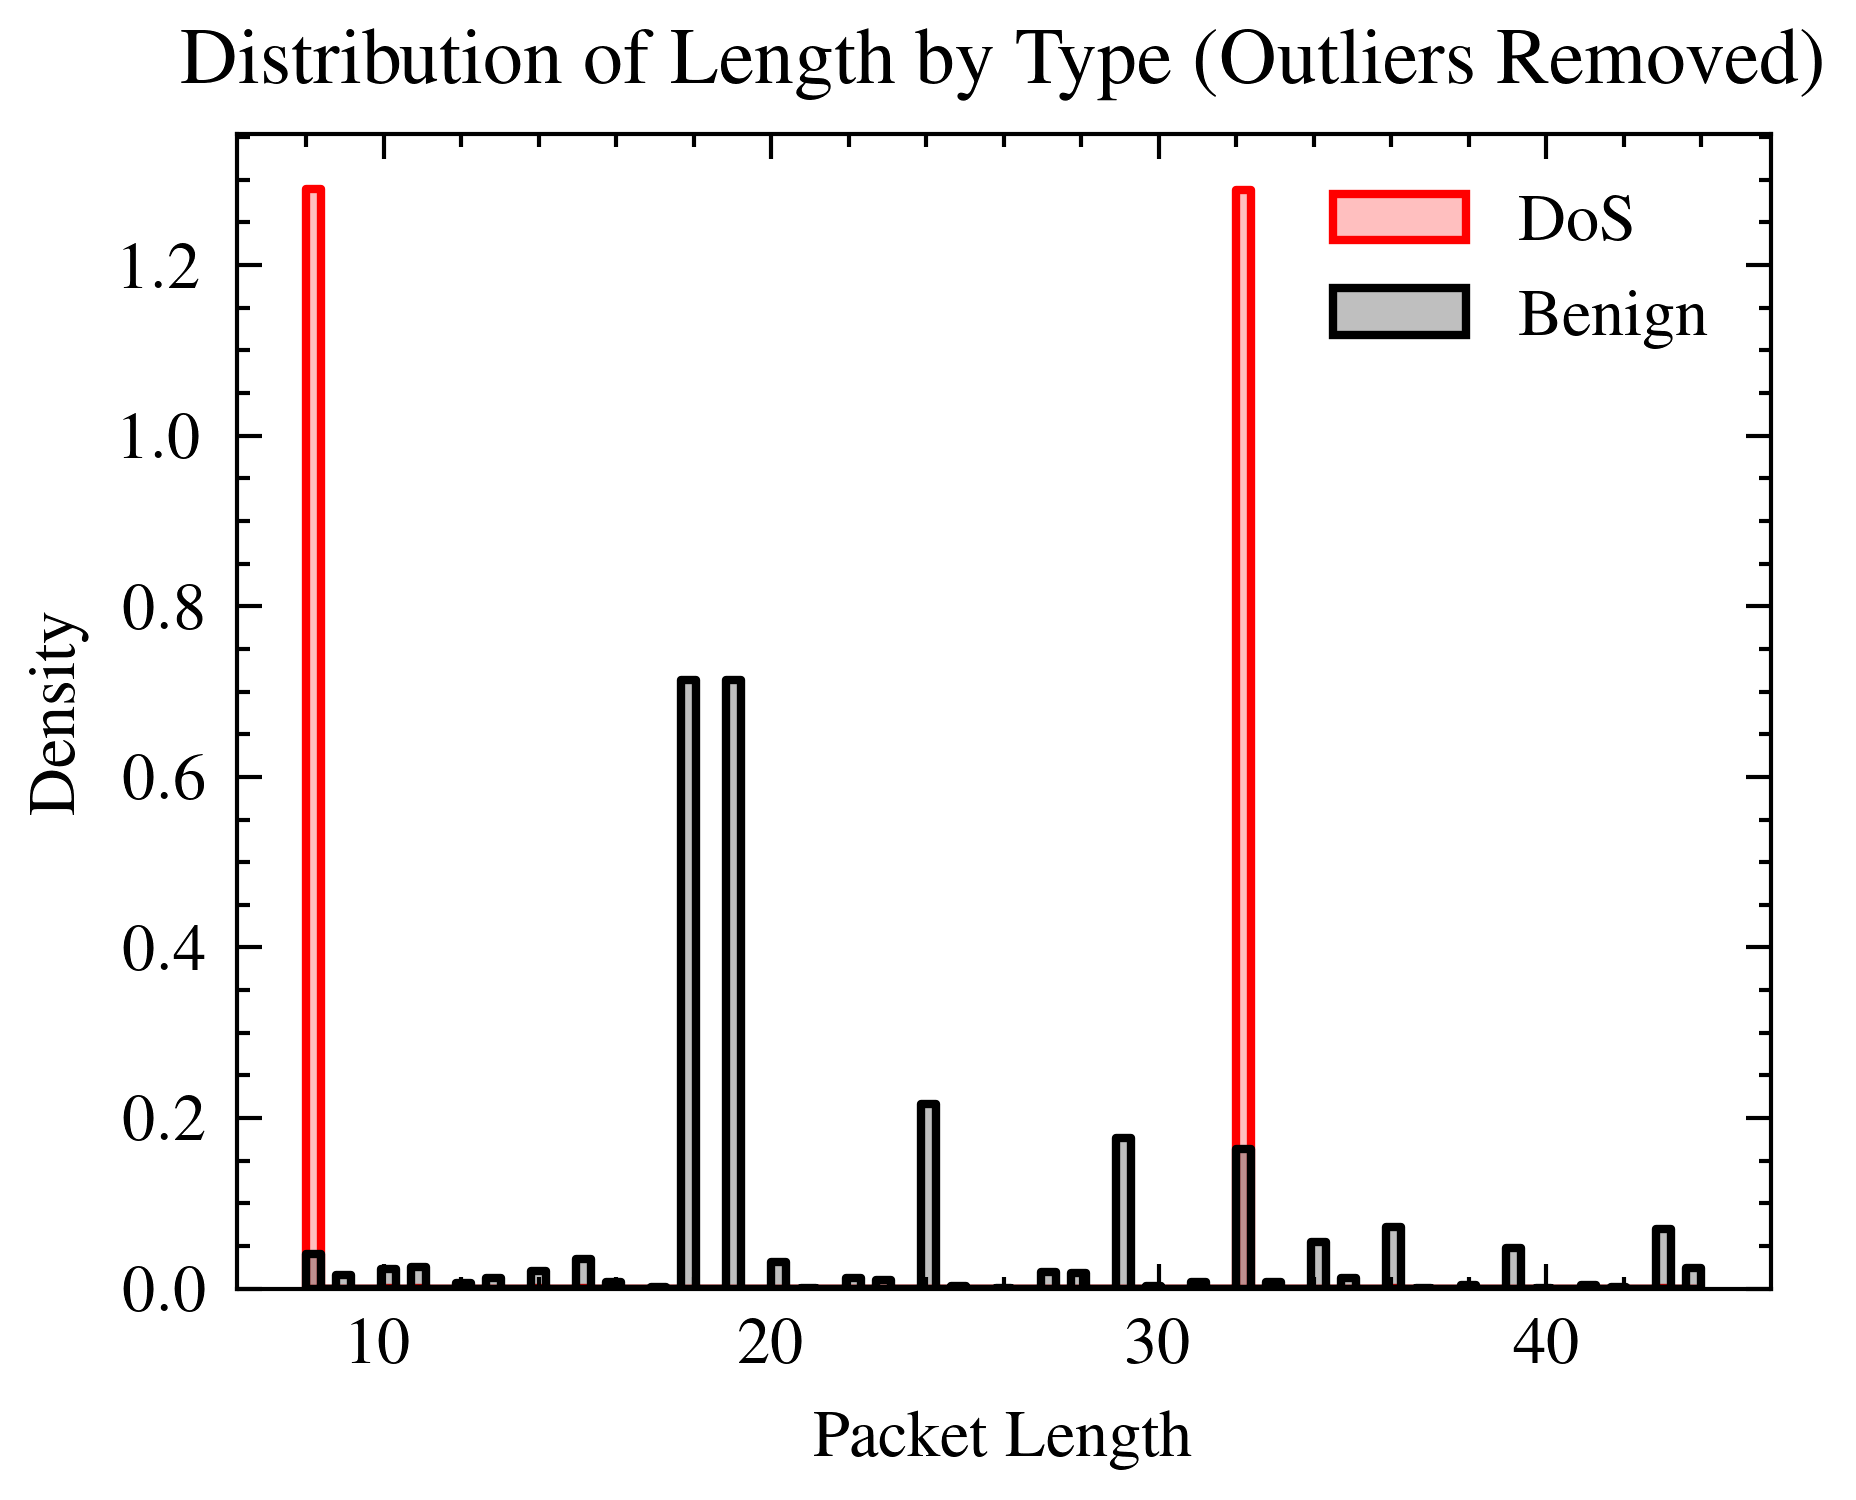

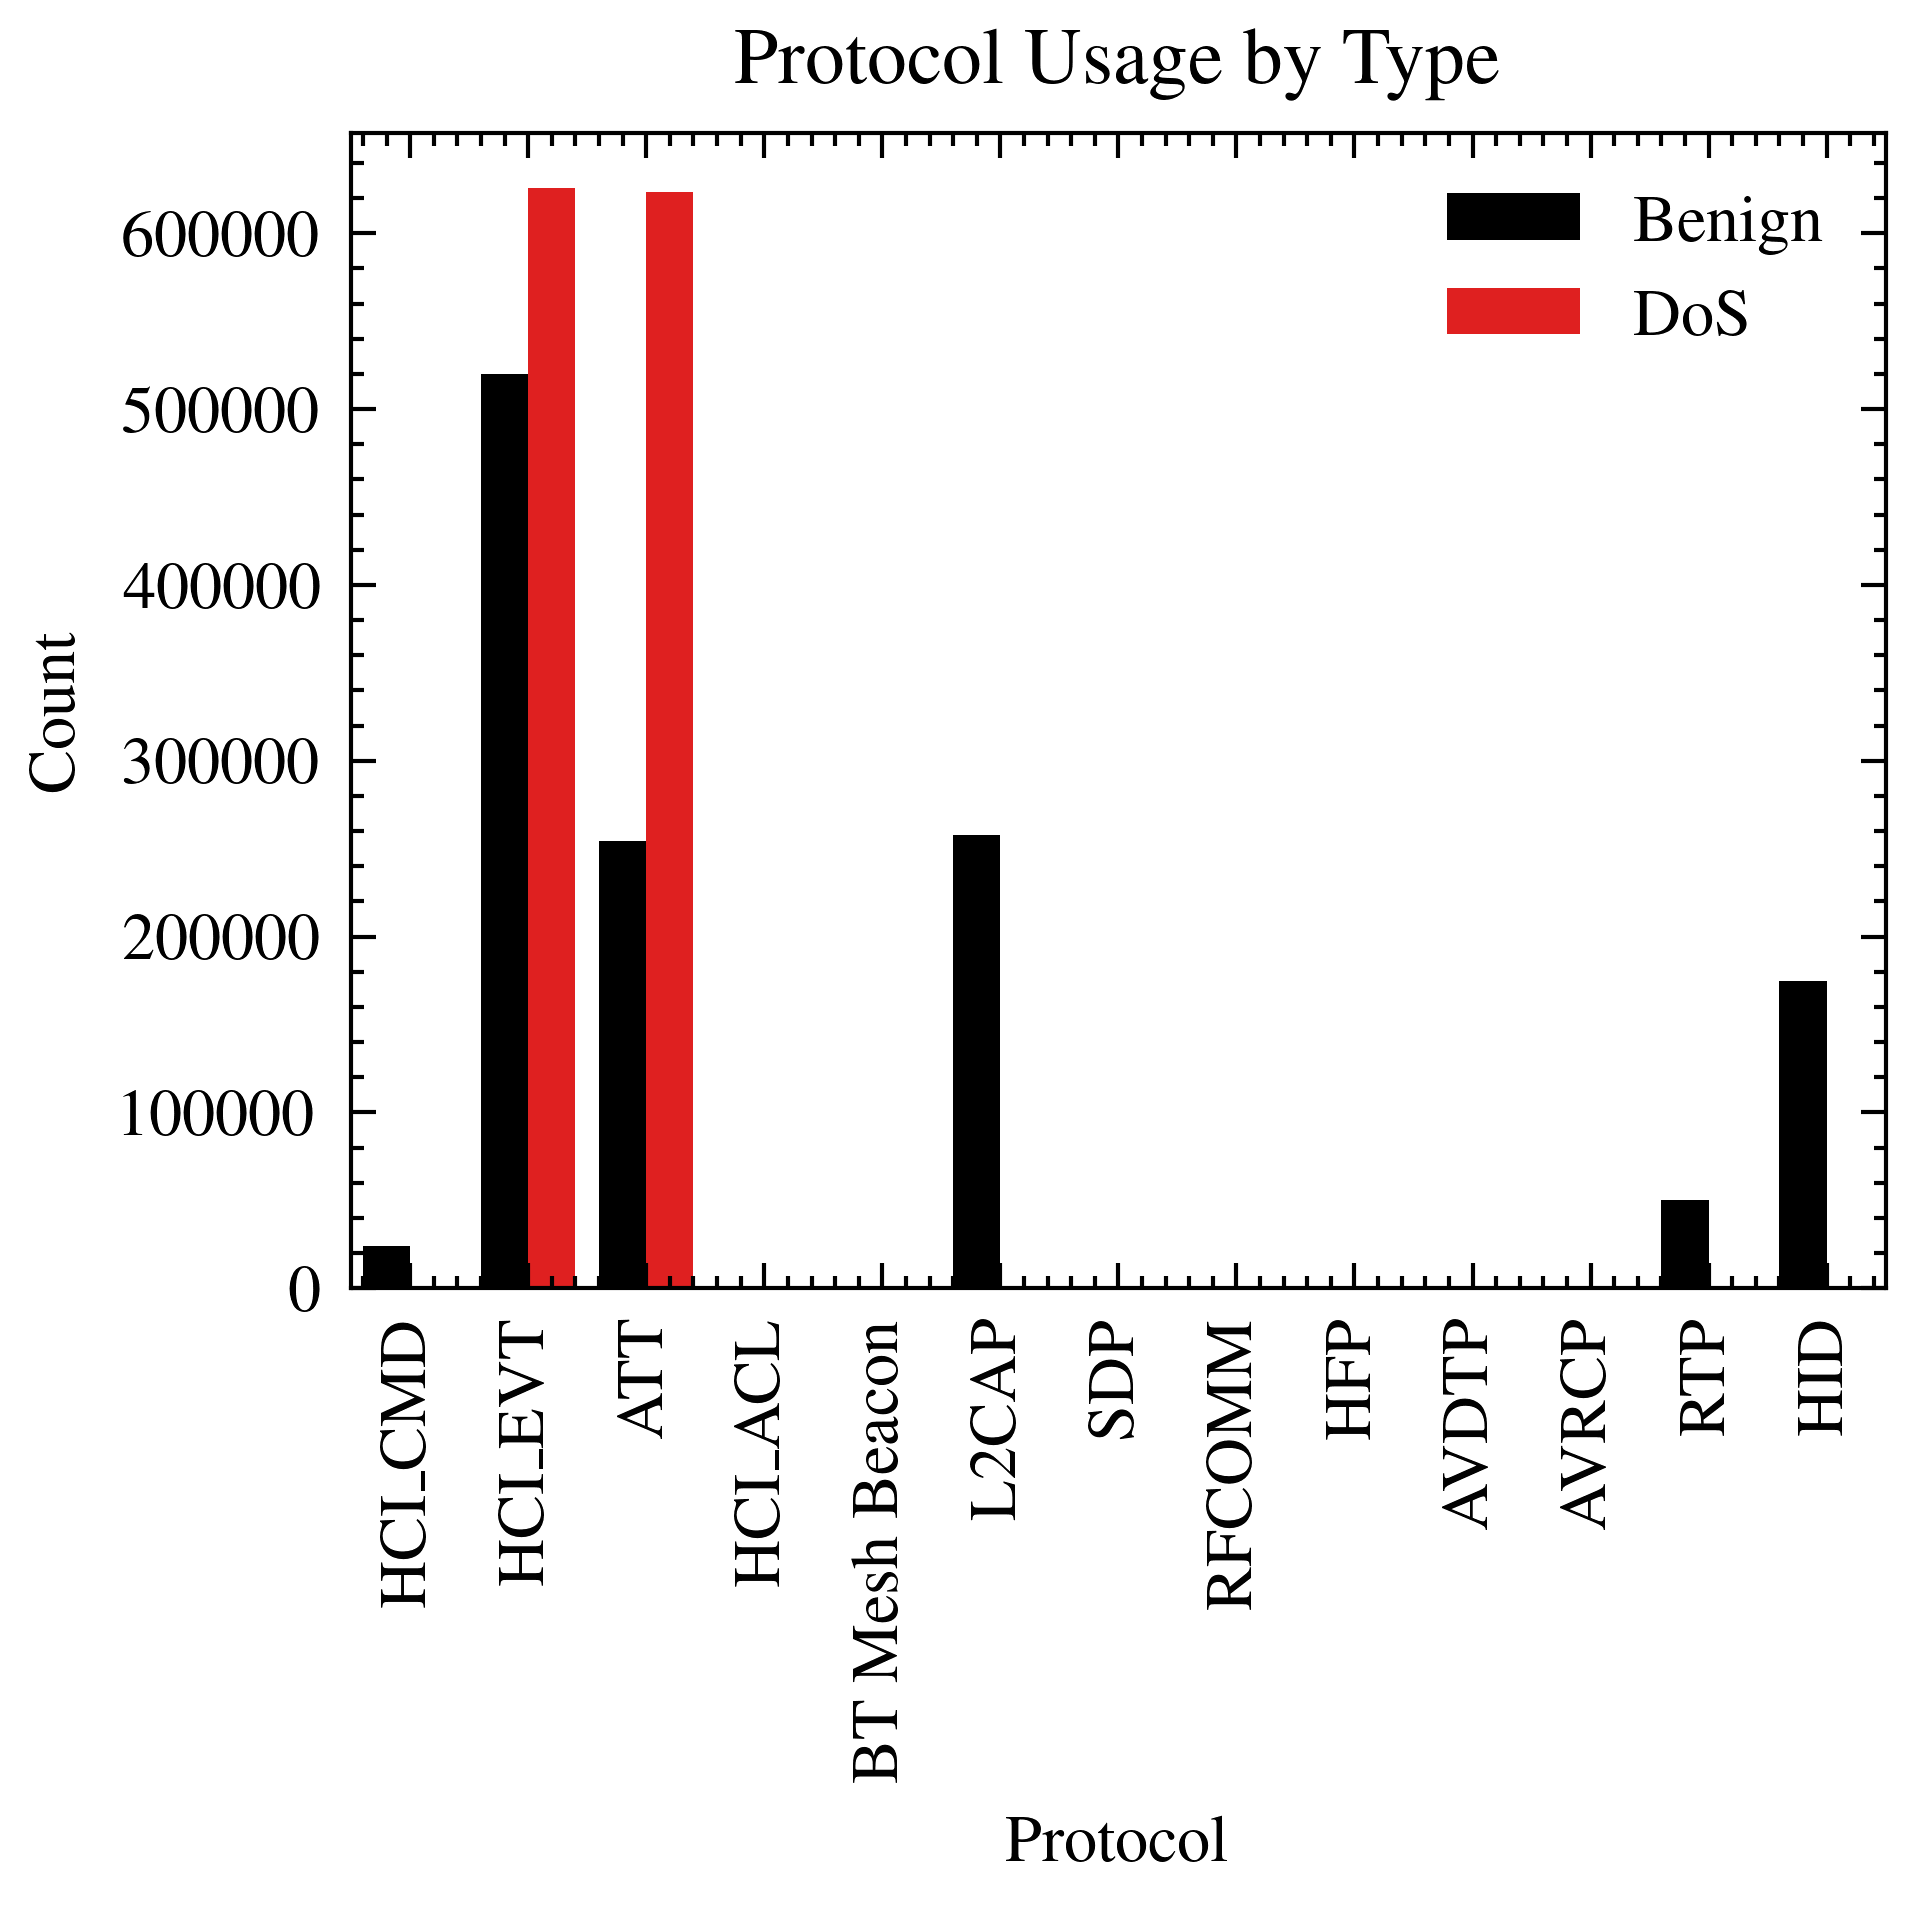

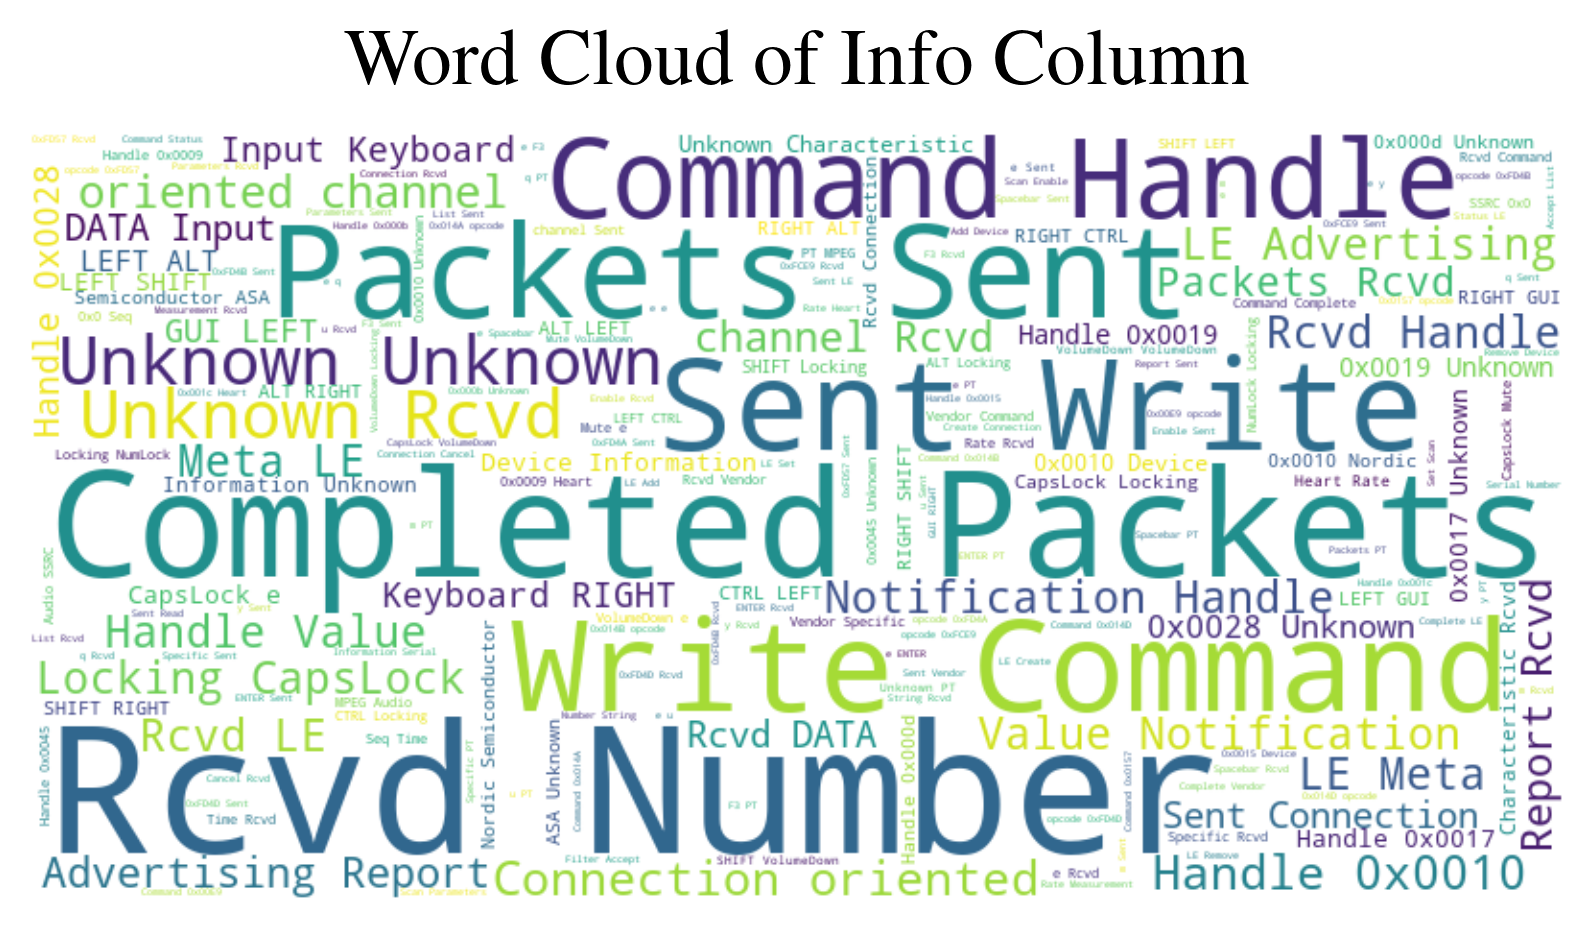

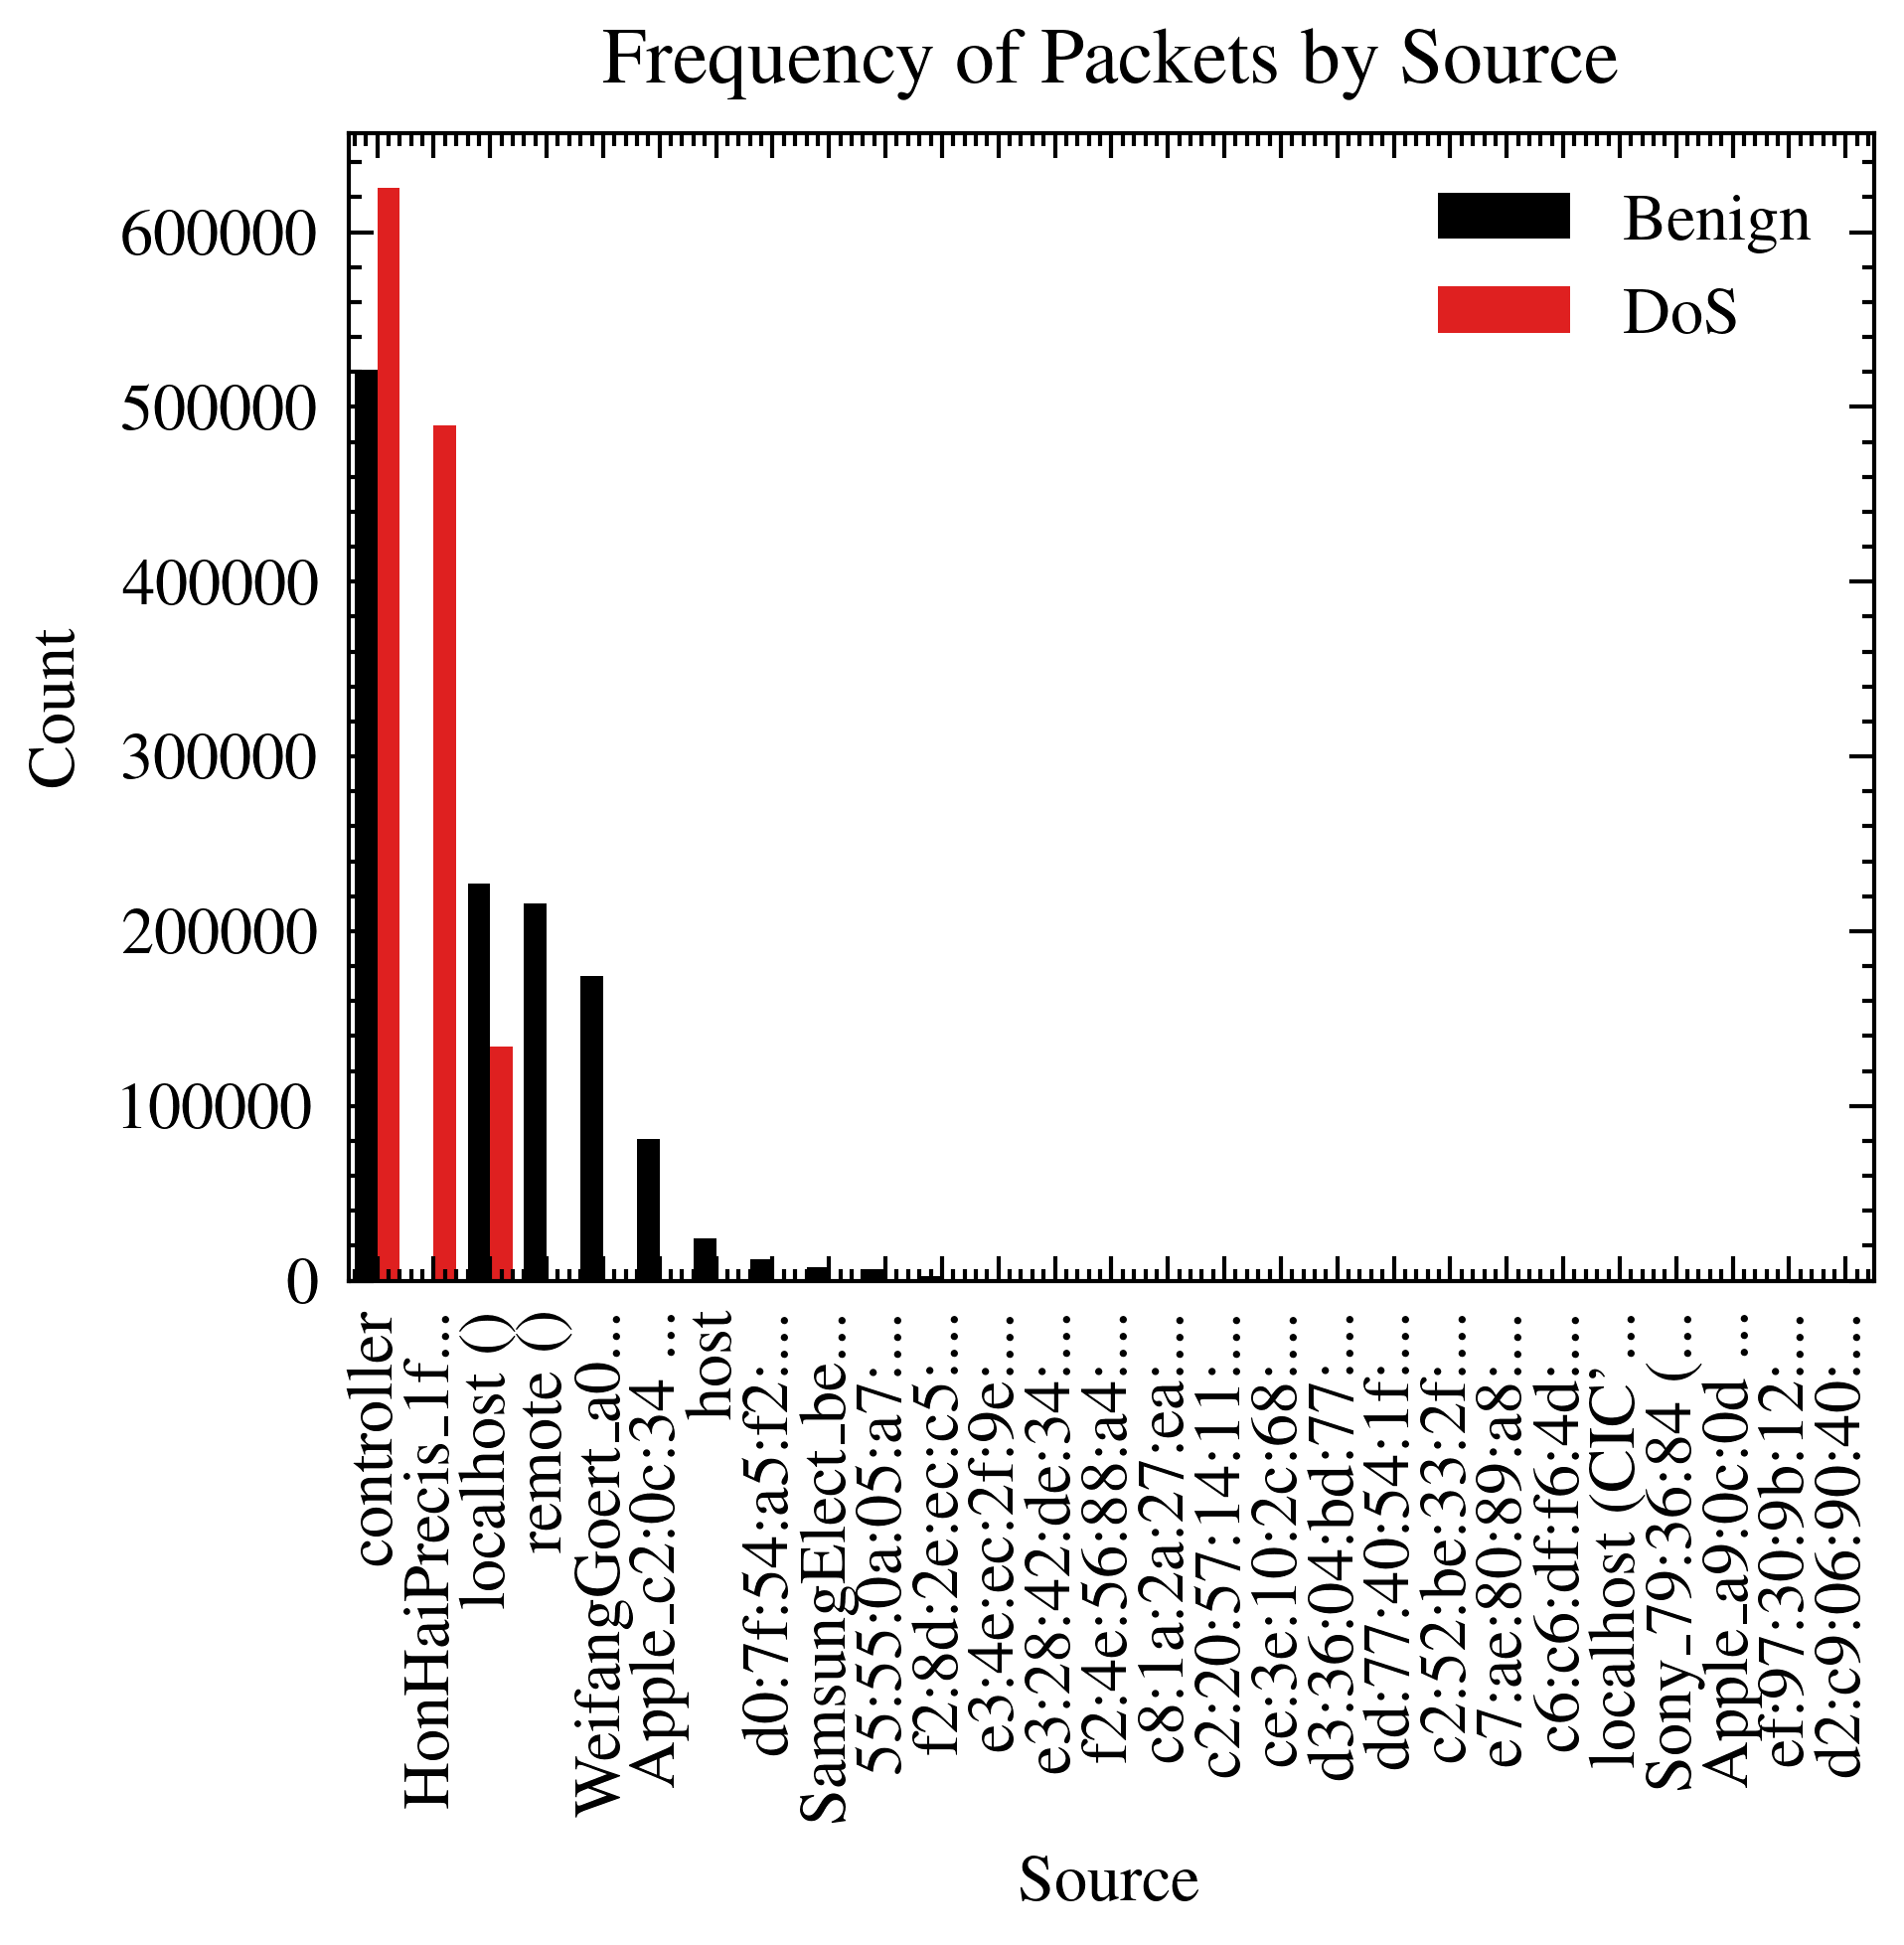

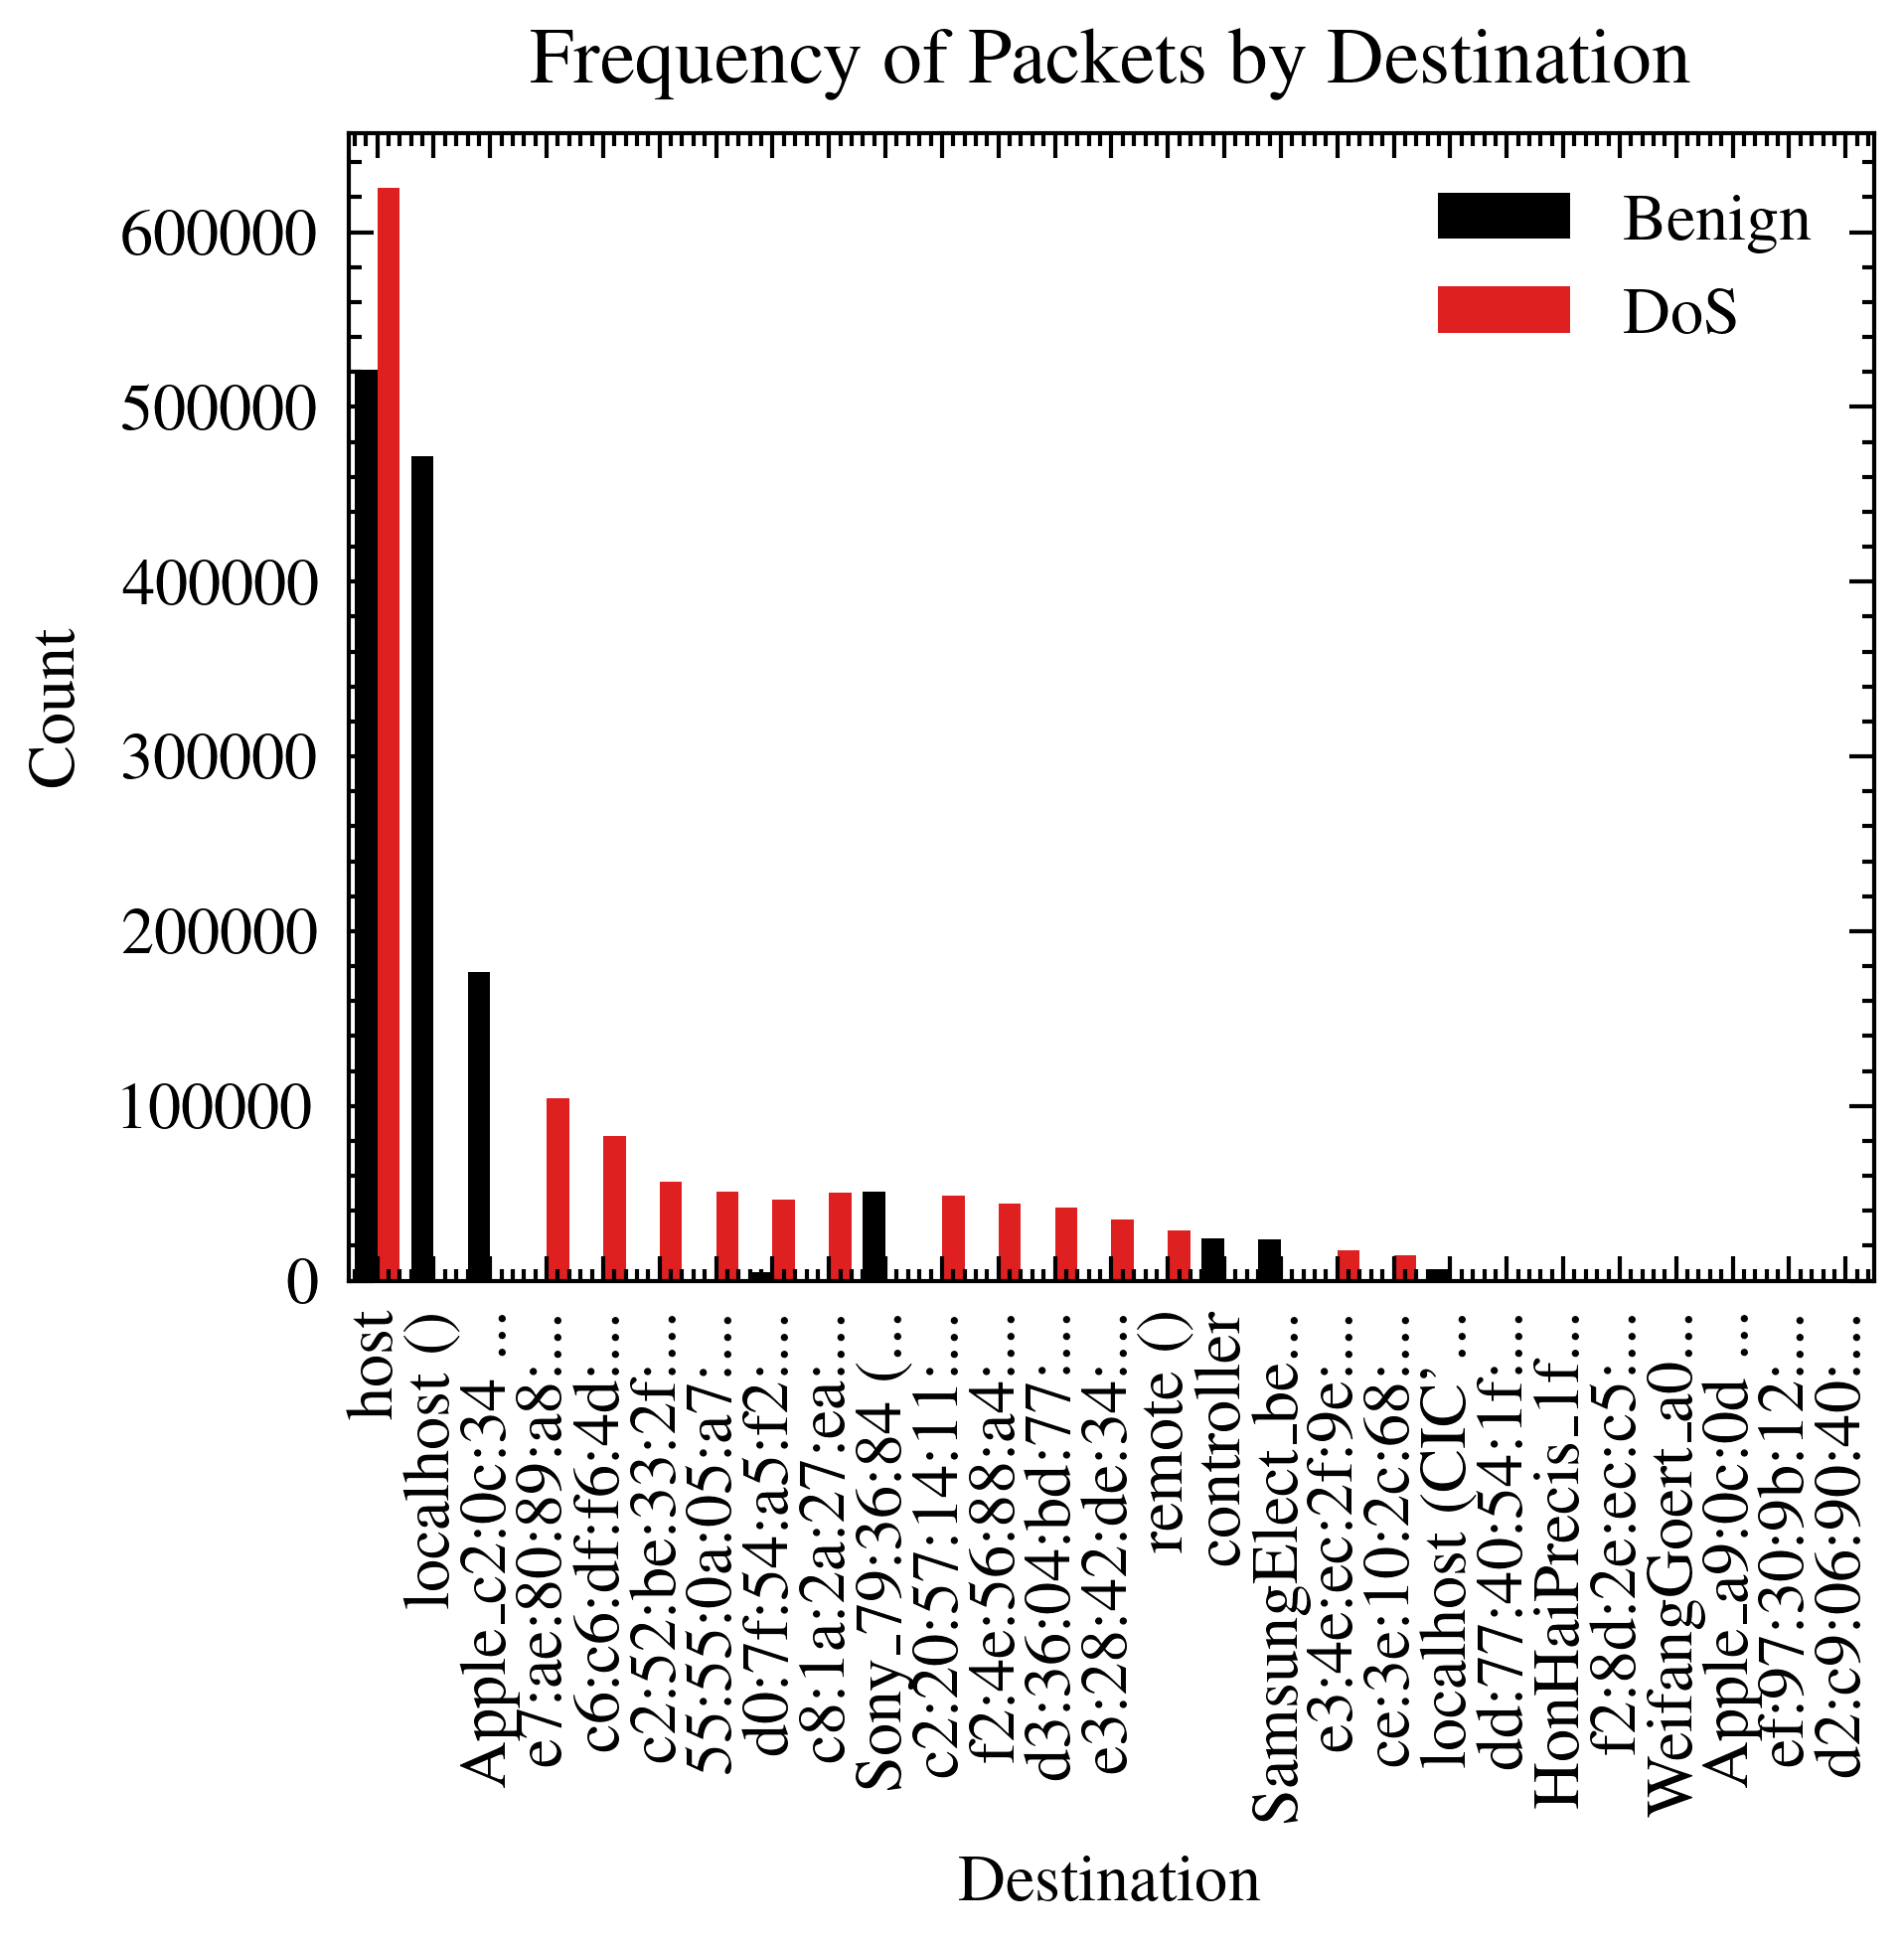

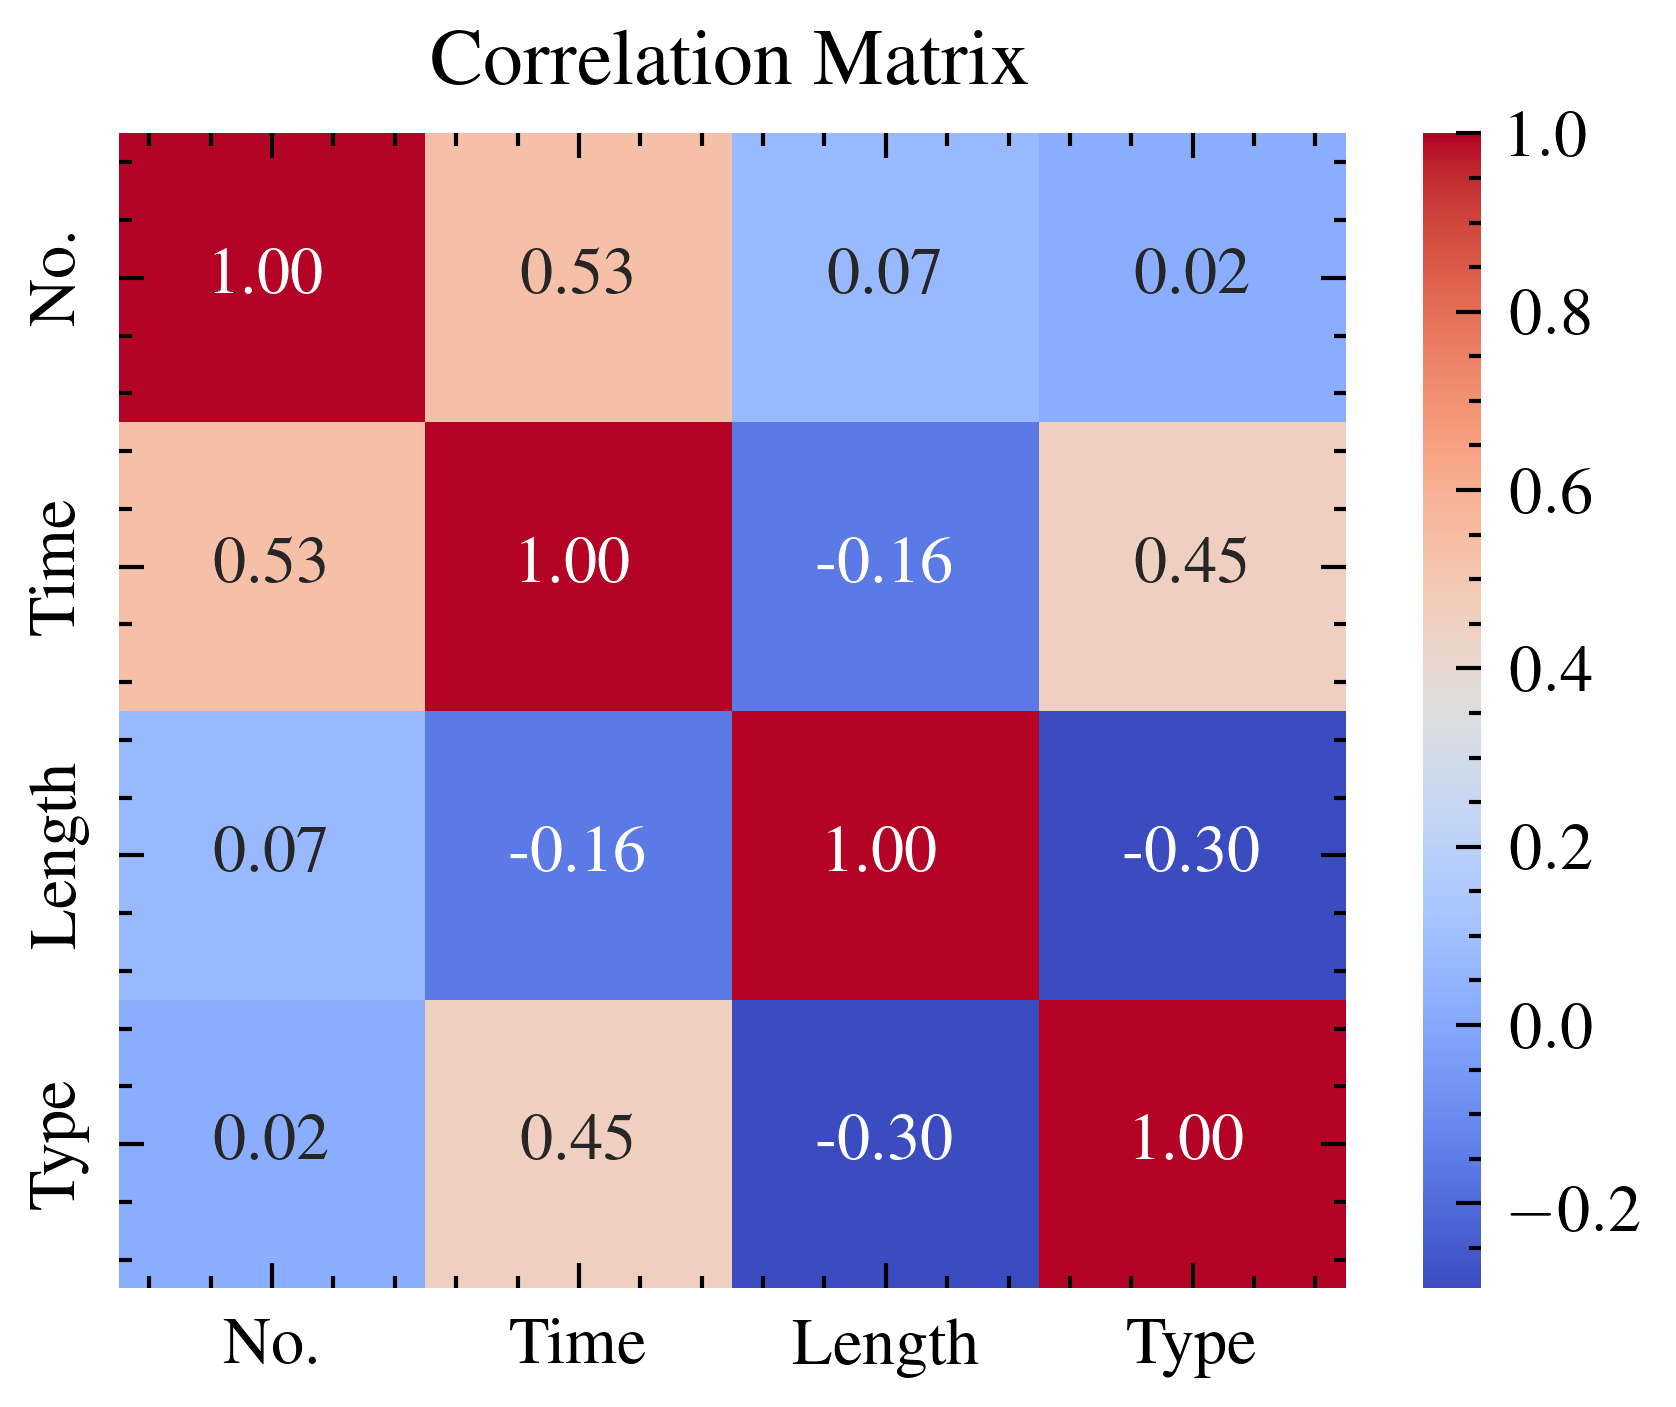

In [7]:
# training and testing with labels
plot_training = train_dataset.copy()
plot_training["Type"] = train_labels
plot_testing = test_dataset.copy()
plot_testing["Type"] = test_labels
dataset = pd.concat([plot_training, plot_testing], ignore_index=True)
# summary statistics
print(f"Training and Testing dataset statistics:\n{dataset.describe()}\n")

# remove length outliers
lower_bound, upper_bound = dataset["Length"].quantile([0.01, 0.85])
filtered_length = dataset["Length"][
    (dataset["Length"] > lower_bound) & (dataset["Length"] < upper_bound)
]
# histogram of length
plt.figure()
sns.histplot(
    x=filtered_length,
    hue=dataset["Type"],
    element="step",
    stat="density",
    common_norm=False,
)
plt.title("Distribution of Length by Type (Outliers Removed)")
plt.xlabel("Packet Length")
plt.ylabel("Density")
plt.legend(["DoS", "Benign"])
plt.show()

# bar chart for protocol usage
plt.figure()
sns.countplot(x="Protocol", hue="Type", data=dataset)
plt.title("Protocol Usage by Type")
plt.xlabel("Protocol")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.legend(["Benign", "DoS"])
plt.show()

# word cloud for info column
wordcloud = WordCloud(
    width=800, height=400, background_color="white"
).generate(" ".join(dataset["Info"]))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Info Column")
plt.show()

# bar chart for source usage
dataset["Source"] = dataset["Source"].apply(
    lambda x: x if len(x) <= 15 else x[:15] + "..."
)
plt.figure()
sns.countplot(
    x="Source",
    hue="Type",
    data=dataset,
    order=dataset["Source"].value_counts().index,
)
plt.title("Frequency of Packets by Source")
plt.xlabel("Source")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.legend(["Benign", "DoS"])
plt.show()

# bar chart for destination usage
dataset["Destination"] = dataset["Destination"].apply(
    lambda x: x if len(x) <= 15 else x[:15] + "..."
)
plt.figure()
sns.countplot(
    x="Destination",
    hue="Type",
    data=dataset,
    order=dataset["Destination"].value_counts().index,
)
plt.title("Frequency of Packets by Destination")
plt.xlabel("Destination")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.legend(["Benign", "DoS"])
plt.show()

# correlation matrix
plt.figure()
sns.heatmap(
    dataset.select_dtypes(["number"]).corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
)
plt.title("Correlation Matrix")
plt.show()

## Feature Extraction  

In [8]:
# load preprocessed datasets
train_dataset = pd.read_csv(PREPROCESSED_TRAIN)
test_dataset = pd.read_csv(PREPROCESSED_TEST)

In [9]:
# apply tf-idf vectorization to Info column
vectorizer = TfidfVectorizer(max_features=1000)
train_info = vectorizer.fit_transform(train_dataset["Info"])
test_info = vectorizer.transform(test_dataset["Info"])

# apply one-hot encoding to Protocol column
encoder = OneHotEncoder()
train_protocol = encoder.fit_transform(train_dataset[["Protocol"]])
test_protocol = encoder.transform(test_dataset[["Protocol"]])

# apply time delta encoding
train_time = train_dataset[["Time"]].diff().fillna(0)
train_time[train_time < 0] = 0  # replace negatives (indicating new session)
train_time = csr_matrix(train_time)
test_time = test_dataset[["Time"]].diff().fillna(0)  # filter outliers
test_time[test_time < 0] = 0  # replace negatives (indicating new session)
test_time = csr_matrix(test_time)

# apply standard scaling to Length column
scaler = StandardScaler()
train_length = scaler.fit_transform(train_dataset[["Length"]])
test_length = scaler.transform(test_dataset[["Length"]])

# apply feature hashing to Source and Destination columns
hasher = FeatureHasher(n_features=20, input_type="string")
train_source = hasher.transform(train_dataset["Source"].apply(lambda x: [x]))  # type: ignore
test_source = hasher.transform(test_dataset["Source"].apply(lambda x: [x]))  # type: ignore
train_dest = hasher.transform(train_dataset["Destination"].apply(lambda x: [x]))  # type: ignore
test_dest = hasher.transform(test_dataset["Destination"].apply(lambda x: [x]))  # type: ignore

# combine features
train_features = hstack(
    [
        train_time,
        train_source,
        train_dest,
        train_protocol,
        train_length,
        train_info,
    ]
)
test_features = hstack(
    [
        test_time,
        test_source,
        test_dest,
        test_protocol,
        test_length,
        test_info,
    ]
)

In [10]:
# write features and models to files
save_npz(FEATURES_TRAIN, train_features)
save_npz(FEATURES_TEST, test_features)
_ = dump(vectorizer, VECTORIZER_MODEL)
_ = dump(encoder, ENCODER_MODEL)
_ = dump(hasher, HASHER_MODEL)

TF-IDF Vocabulary size: 1000
One-Hot Encoding unique categories: 13
Standard Scaling features count: 1
Feature Hashing features count: 20
Total number of features: 1055


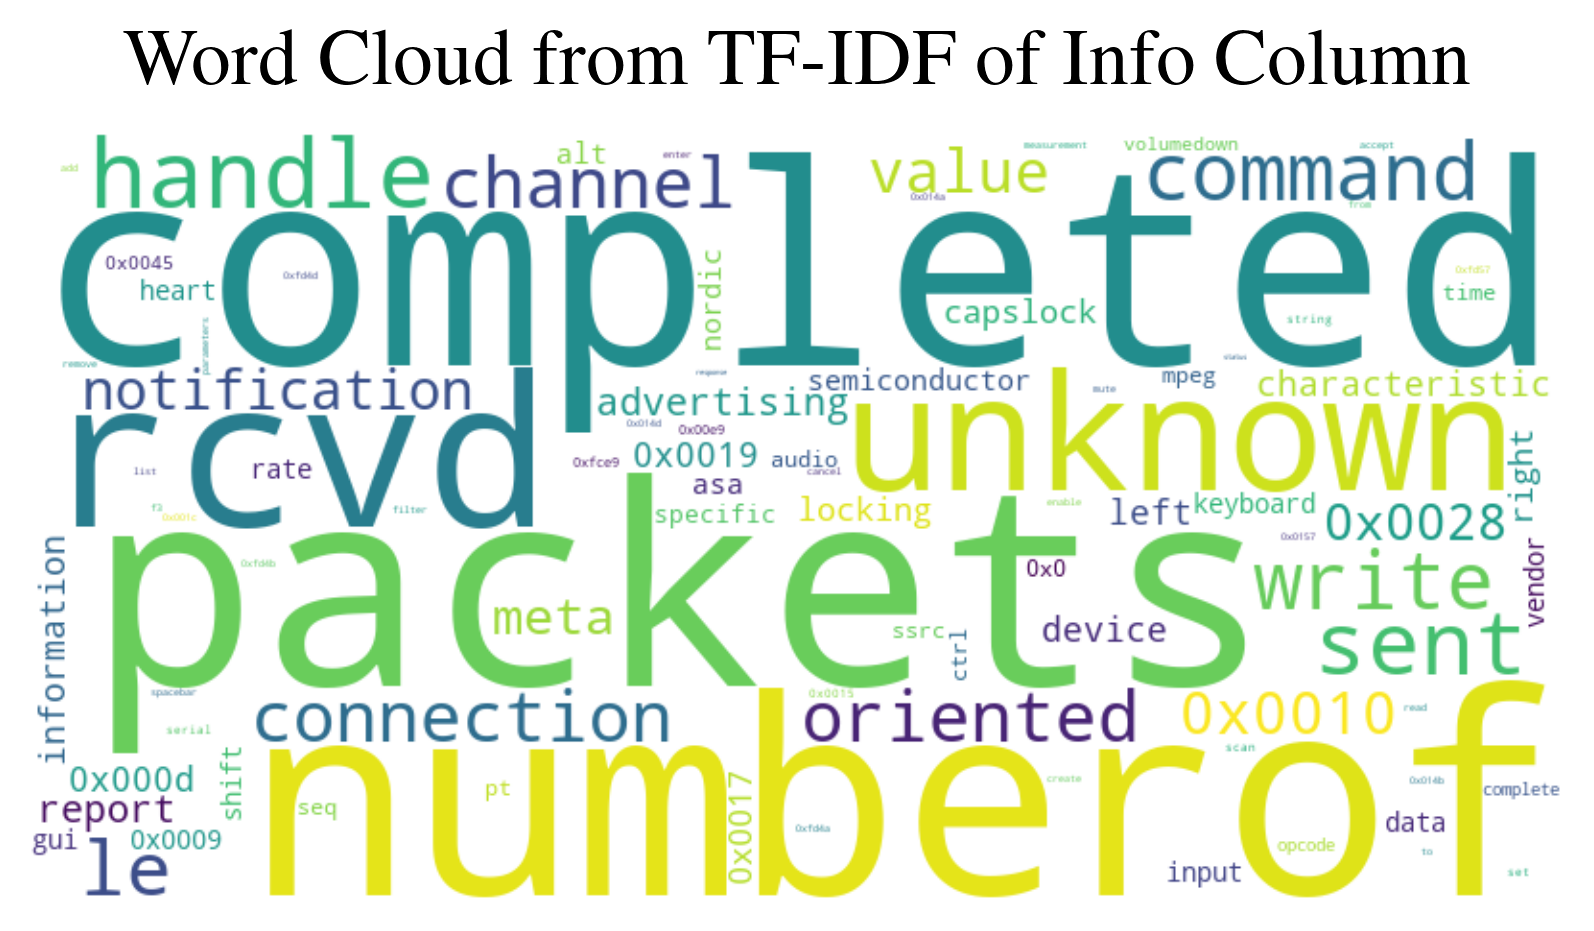

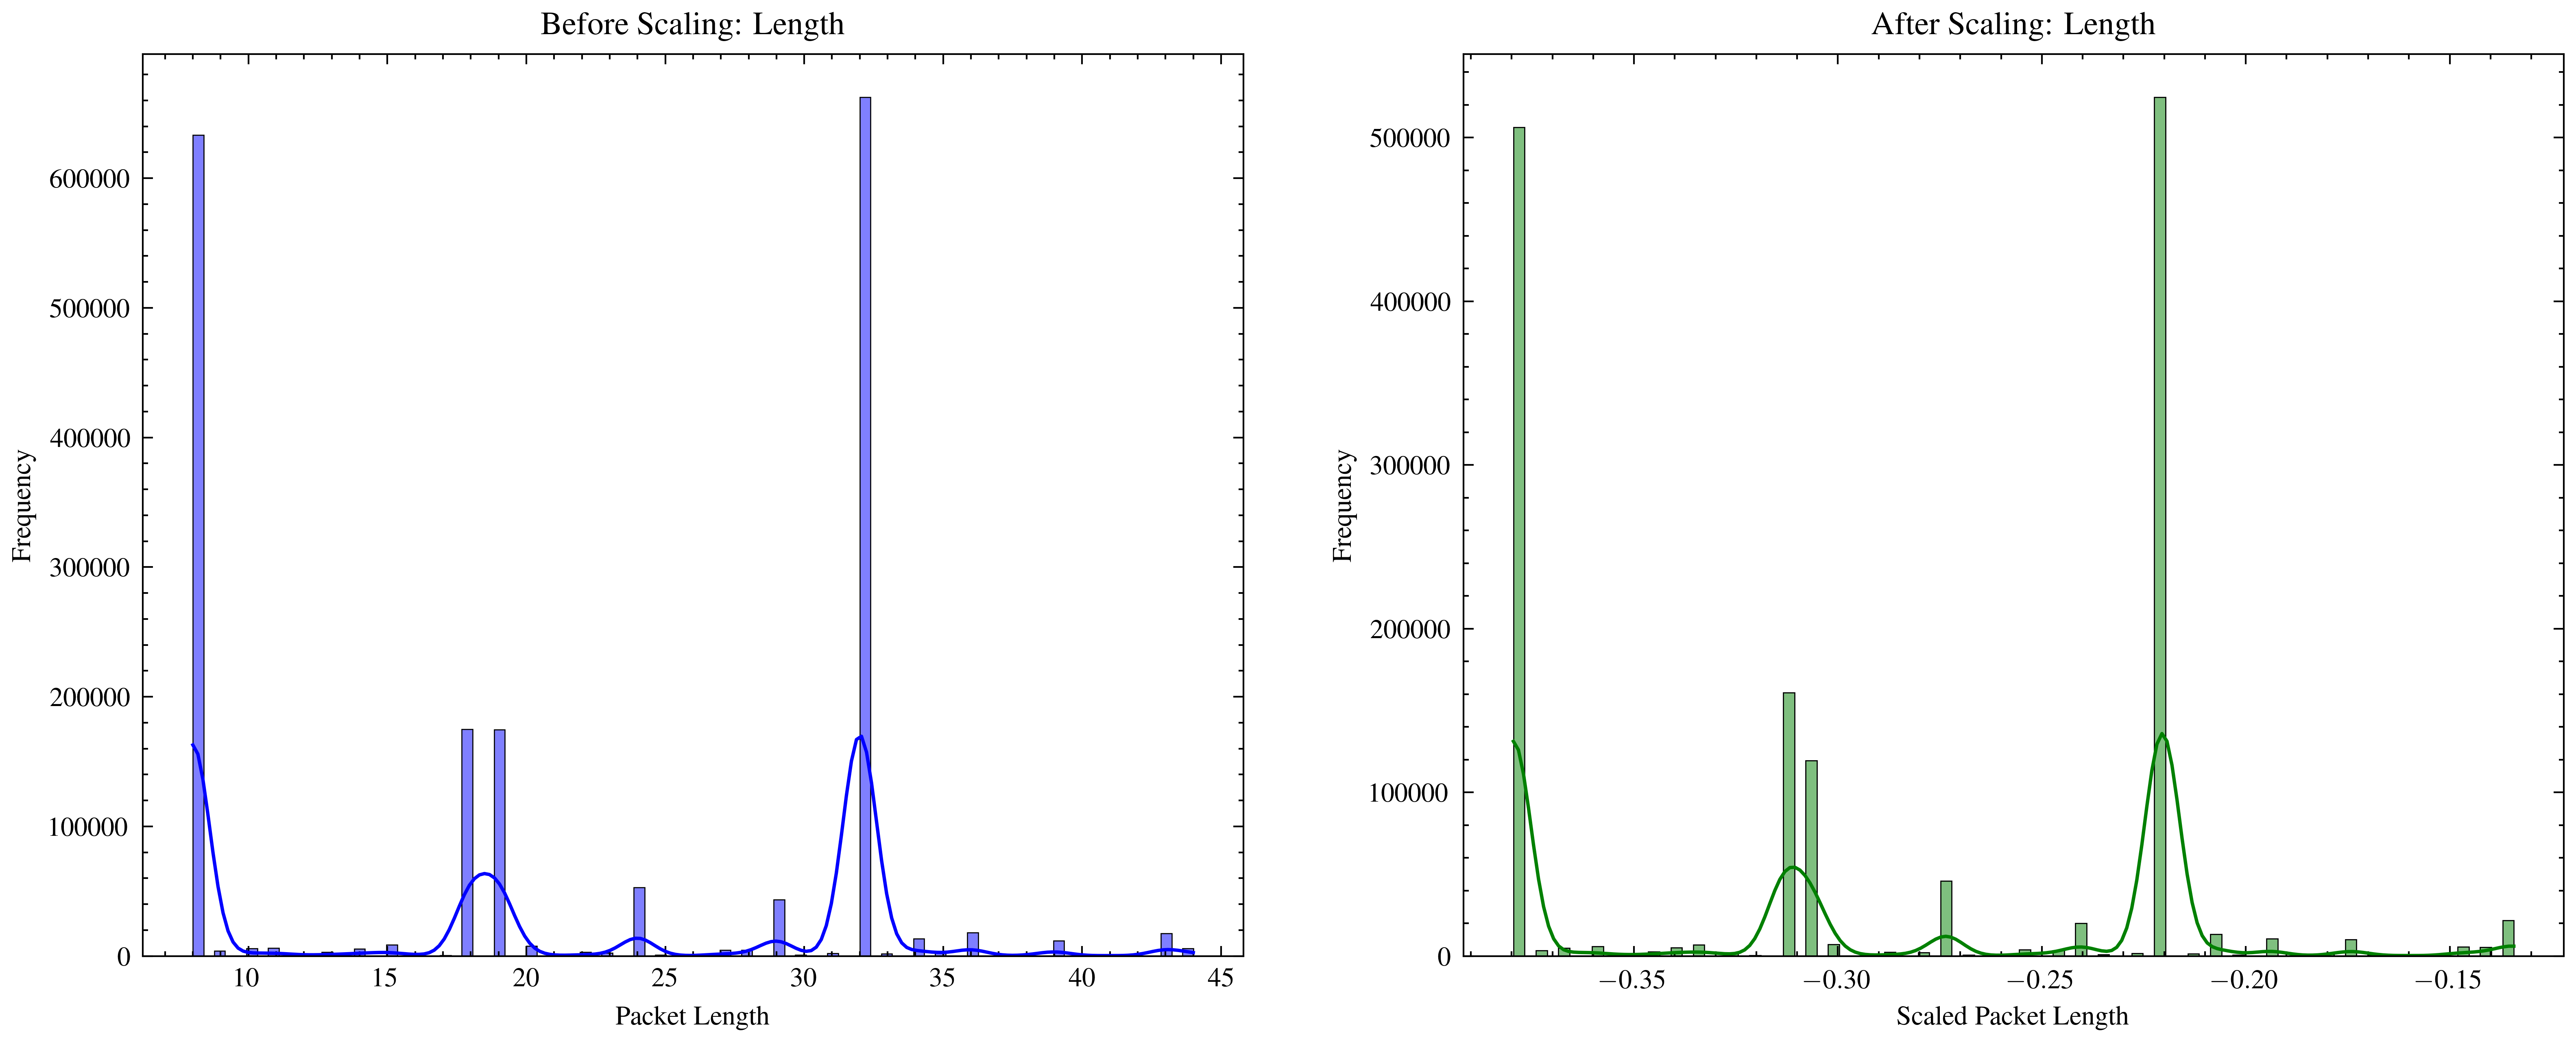

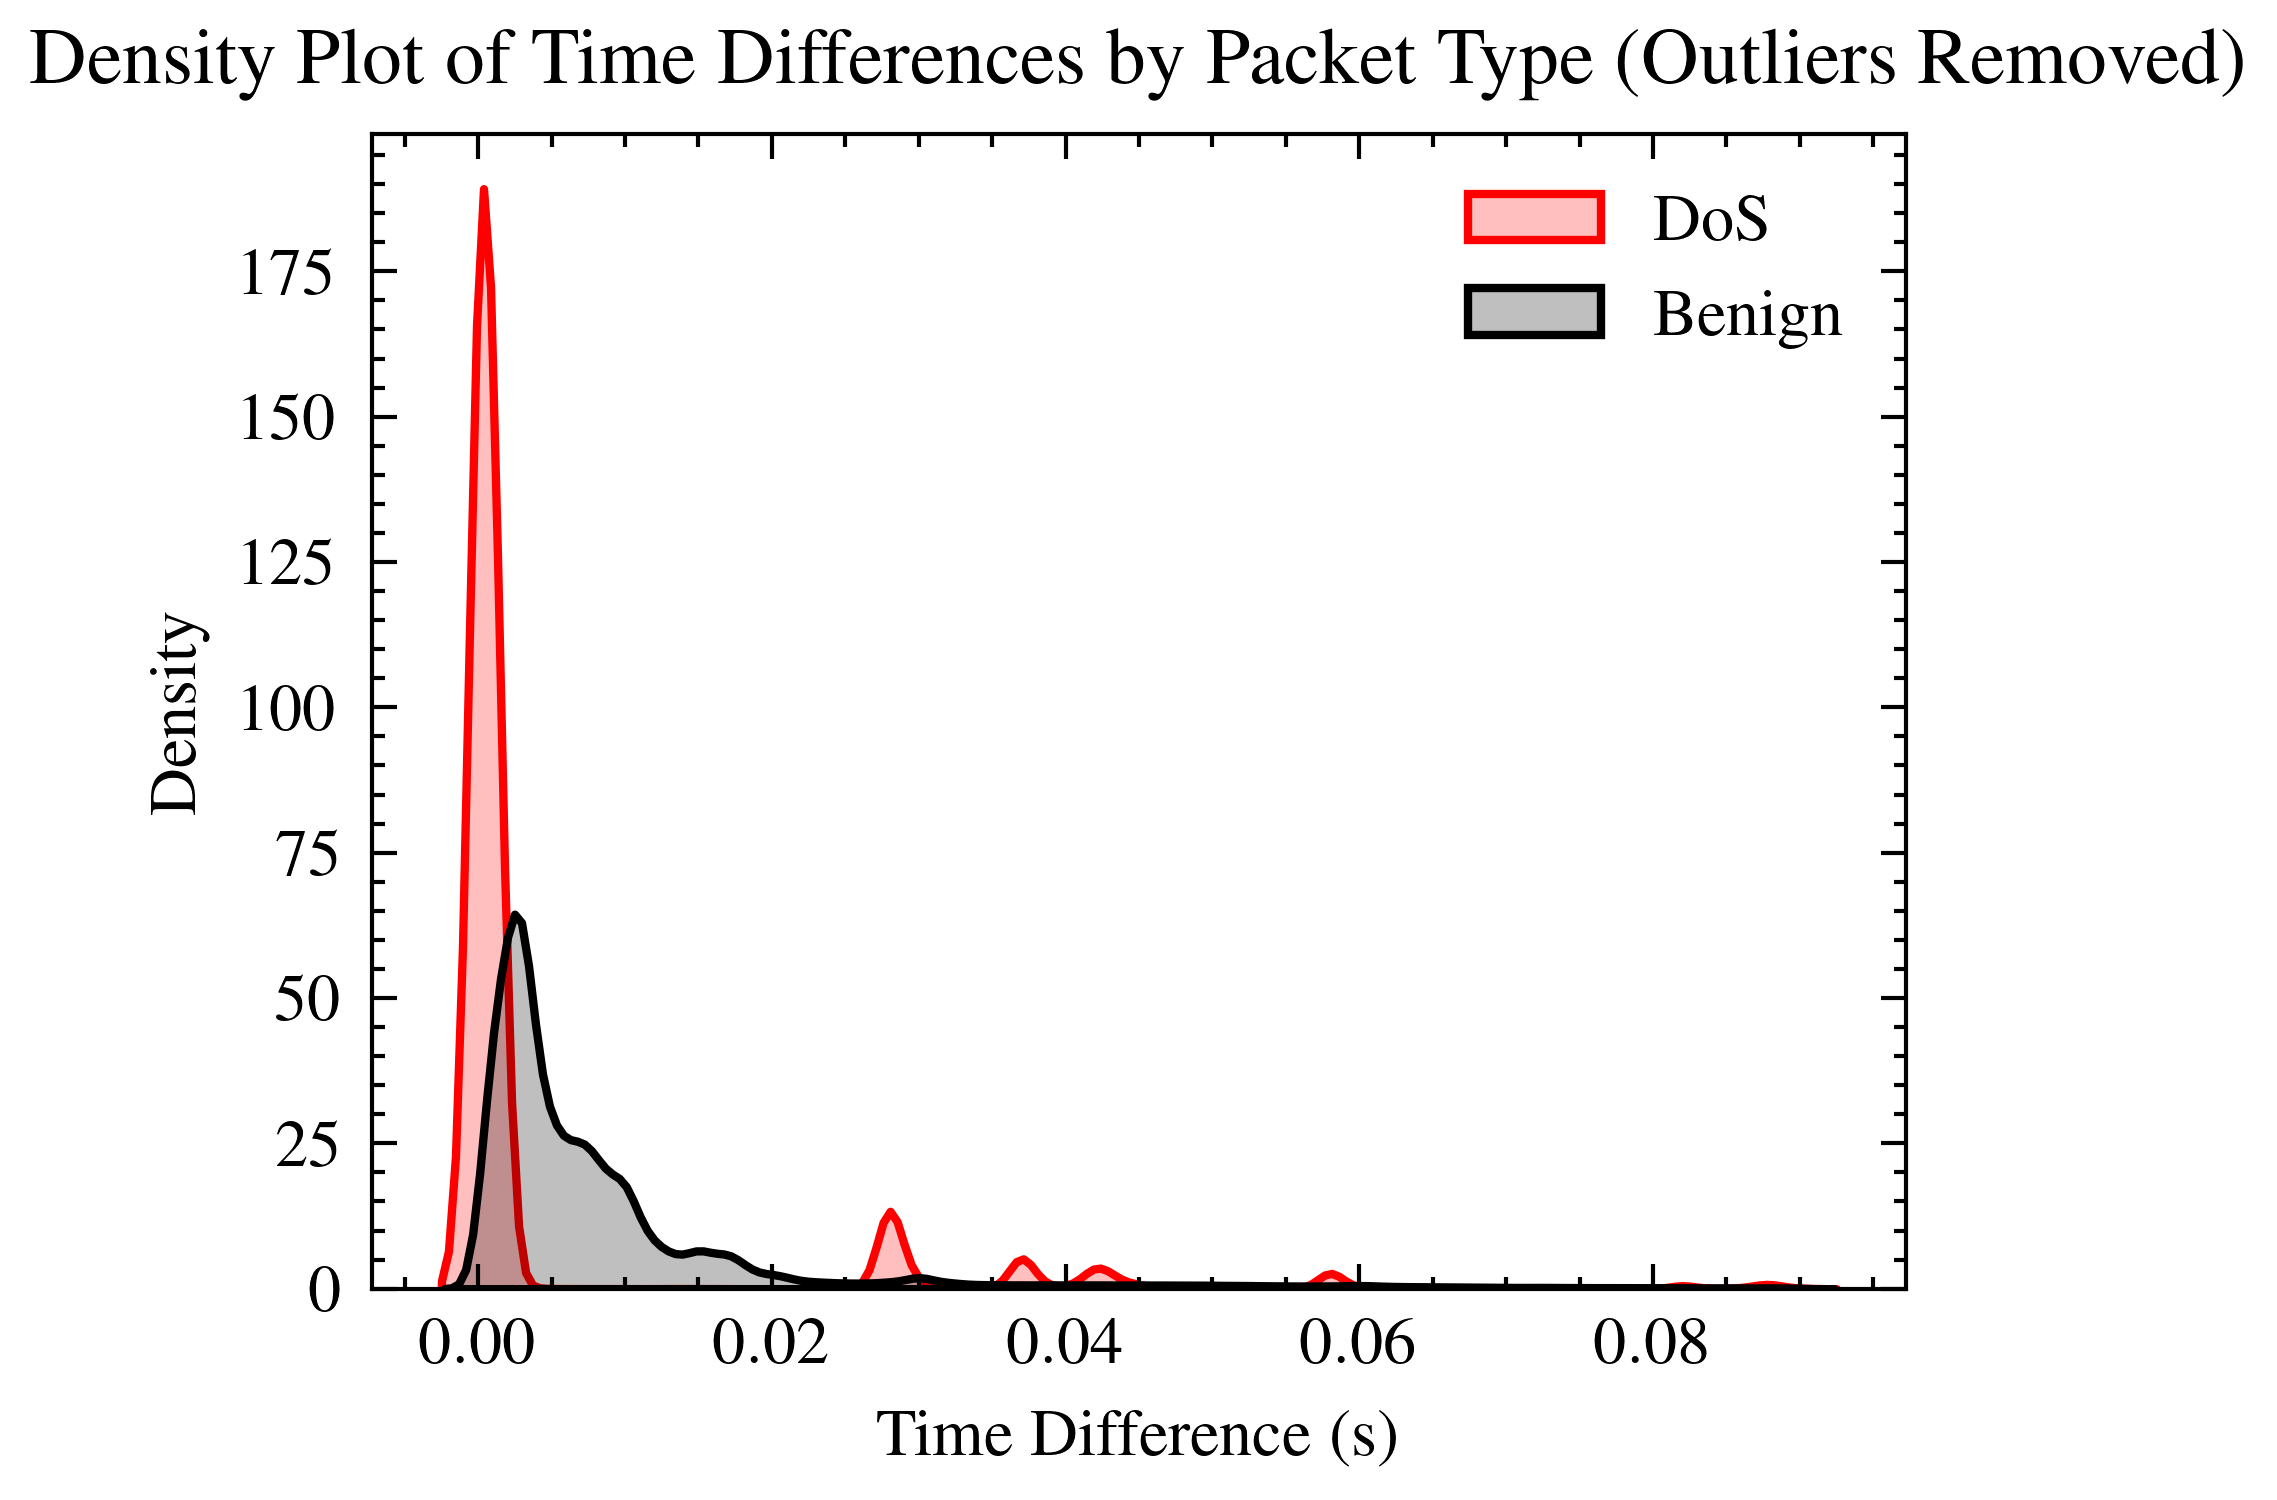

In [11]:
# report feature extraction results
print(f"TF-IDF Vocabulary size: {len(vectorizer.vocabulary_)}")
print(f"One-Hot Encoding unique categories: {len(encoder.categories_[0])}")  # type: ignore
print(f"Standard Scaling features count: {train_length.shape[1]}")
print(f"Feature Hashing features count: {train_source.shape[1]}")
print(f"Total number of features: {train_features.shape[1]}")

# word cloud of the info column
features = vectorizer.get_feature_names_out()
scores = np.ravel(train_info.sum(axis=0))
word_scores = dict(zip(features, scores))
wordcloud = WordCloud(
    width=800, height=400, background_color="white"
).generate_from_frequencies(word_scores)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud from TF-IDF of Info Column")
plt.show()

# remove outliers
train_length_series = pd.Series(train_length.ravel())
lower_bound, upper_bound = train_length_series.quantile([0.01, 0.85])
filtered_length = train_length[
    (train_length > lower_bound) & (train_length < upper_bound)
]
lower_bound, upper_bound = dataset["Length"].quantile([0.01, 0.85])
filtered_original_length = dataset["Length"][
    (dataset["Length"] > lower_bound) & (dataset["Length"] < upper_bound)
]
# histograms of the Length column before and after scaling
fig, ax = plt.subplots(1, 2, figsize=(12.8, 4.8))
sns.histplot(filtered_original_length, kde=True, ax=ax[0], color="blue")
ax[0].set_title("Before Scaling: Length")
ax[0].set_xlabel("Packet Length")
ax[0].set_ylabel("Frequency")
sns.histplot(filtered_length, kde=True, ax=ax[1], color="green")
ax[1].set_title("After Scaling: Length")
ax[1].set_xlabel("Scaled Packet Length")
ax[1].set_ylabel("Frequency")
plt.show()

# filter out outliers from time differences
time_diffs = np.ravel(train_time.toarray())
time_df = pd.DataFrame({"Time_Diffs": time_diffs, "Type": train_labels})
lower_bound, upper_bound = time_df["Time_Diffs"].quantile([0.01, 0.99])
filtered_time_df = time_df[
    (time_df["Time_Diffs"] > lower_bound)
    & (time_df["Time_Diffs"] < upper_bound)
]
# plot density of time differences
plt.figure()
sns.kdeplot(data=filtered_time_df, x="Time_Diffs", hue="Type", fill=True)
plt.title("Density Plot of Time Differences by Packet Type (Outliers Removed)")
plt.xlabel("Time Difference (s)")
plt.ylabel("Density")
plt.legend(["DoS", "Benign"])
plt.show()

## Model Training 

In [12]:
# load features and labels
train_features = load_npz(FEATURES_TRAIN)
train_labels = np.load(LABELS_TRAIN)

In [13]:
# report hardware information
print("Hardware information:")
# print(f"\tPlatform: {os.uname().sysname}")
# print(f"\tProcessor: {os.uname().machine}")
print(f"\tNumber of CPU cores: {os.cpu_count()}")
# mem = os.sysconf("SC_PAGE_SIZE") * os.sysconf("SC_PHYS_PAGES") / 1024**3
# print(f"\tMemory available: {mem:.2f} GB\n")

# train model
model = LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000, random_state=42, n_jobs=-1)
_ = model.fit(train_features, train_labels)  # type: ignore
model.verbose = 0  # type: ignore # disable verbose mode

Hardware information:
	Number of CPU cores: 12


In [14]:
# write model to file
_ = dump(model, LR_MODEL)

## Evaluation 

In [15]:
# load model and features
model = load(LR_MODEL)
vectorizer = load(VECTORIZER_MODEL)
encoder = load(ENCODER_MODEL)
scaler = load(SCALER_MODEL)
hasher = load(HASHER_MODEL)
test_features = load_npz(FEATURES_TEST)
test_labels = np.load(LABELS_TEST)

Train accuracy: 0.8323843037925734

Confusion matrix:
[[222476  43011]
 [ 43679 208029]]

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84    265487
           1       0.83      0.83      0.83    251708

    accuracy                           0.83    517195
   macro avg       0.83      0.83      0.83    517195
weighted avg       0.83      0.83      0.83    517195



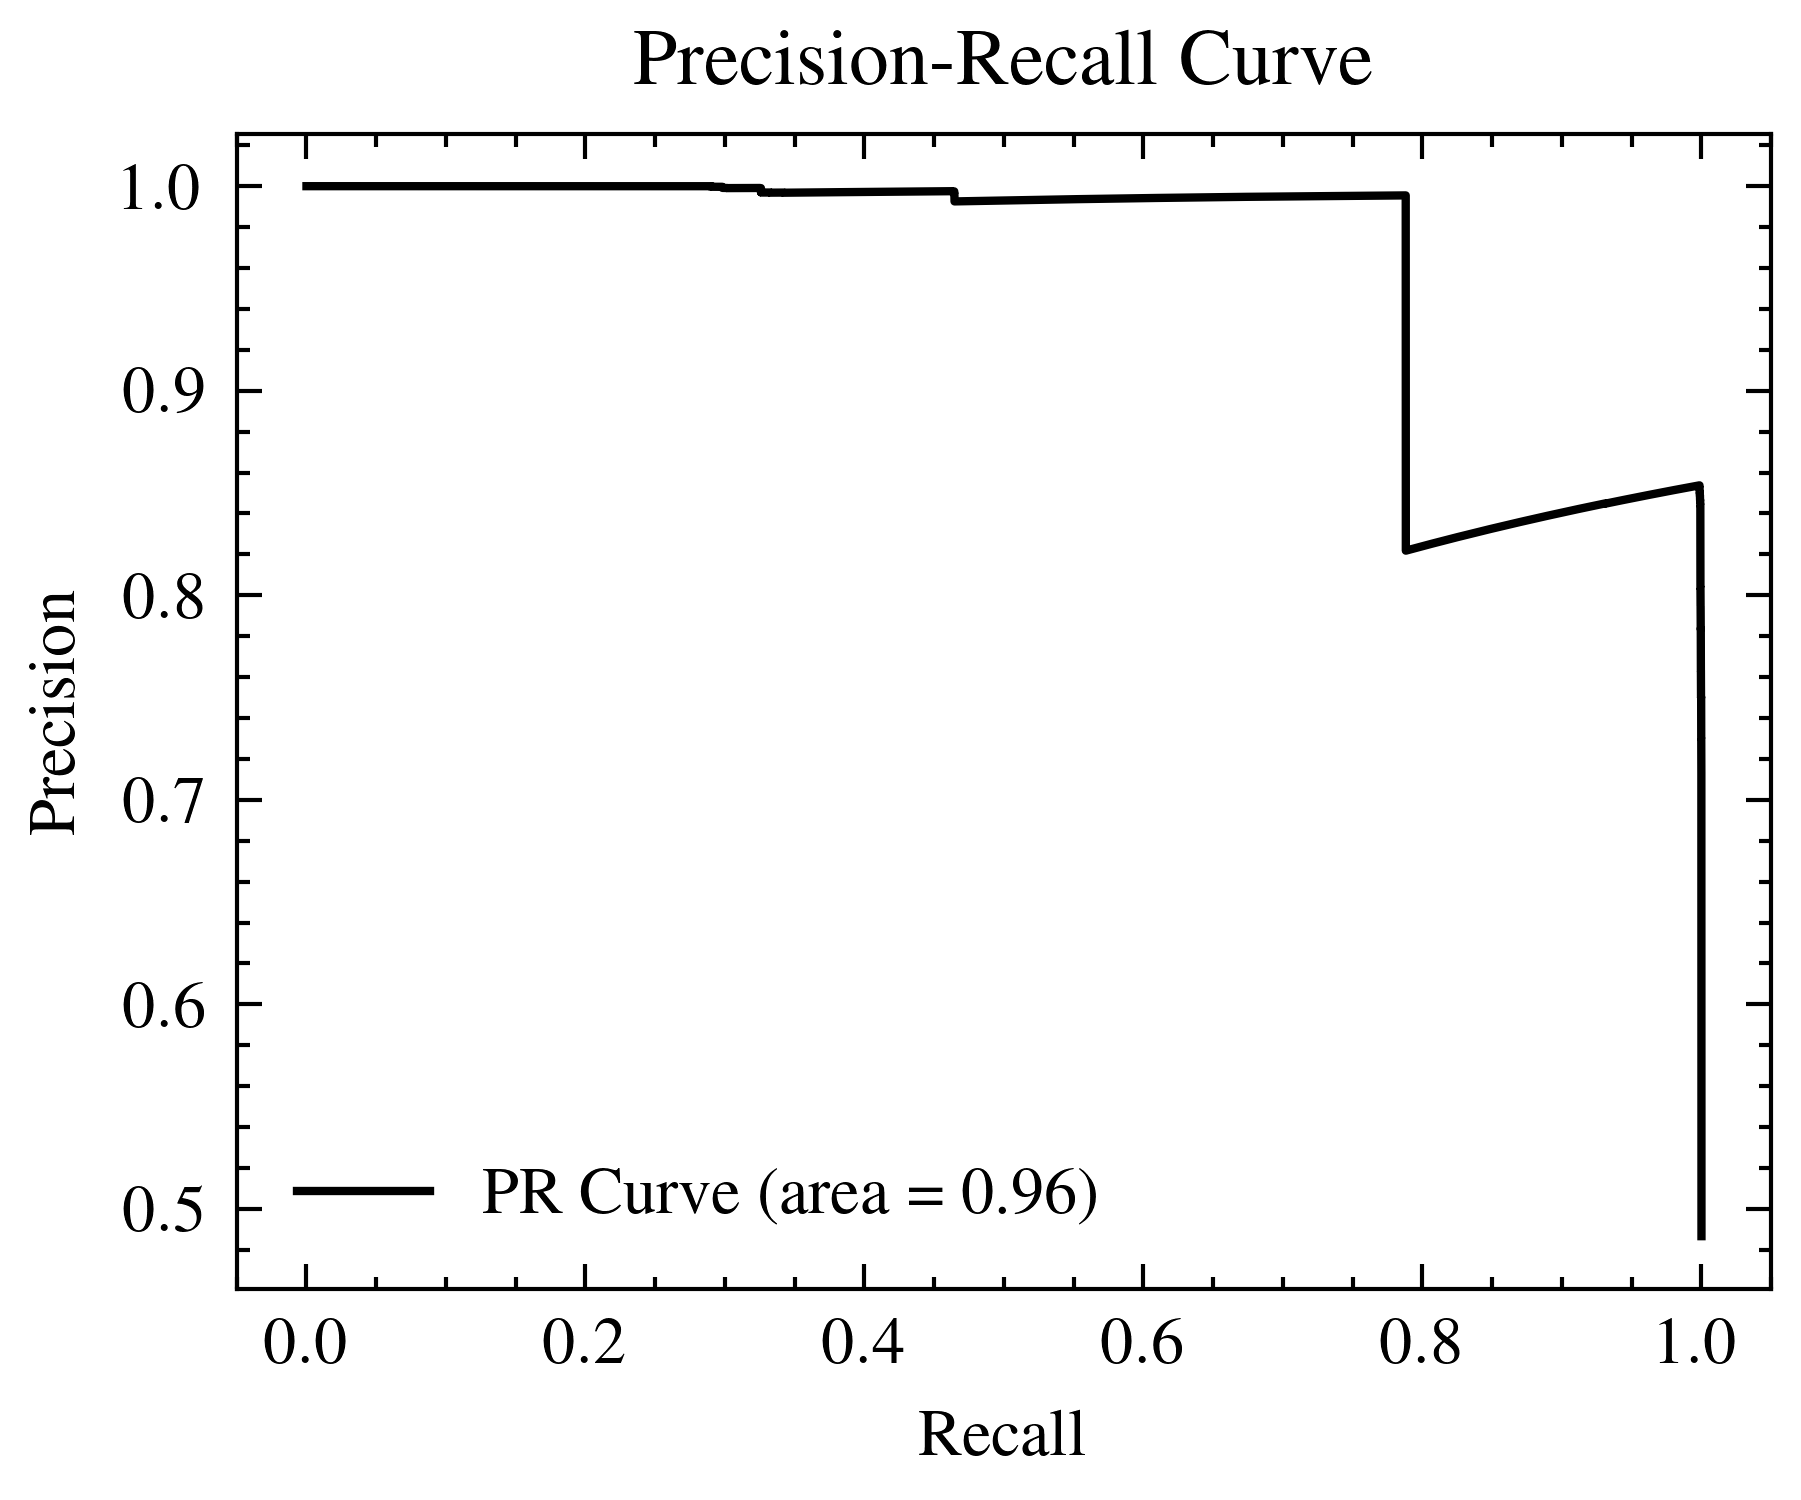

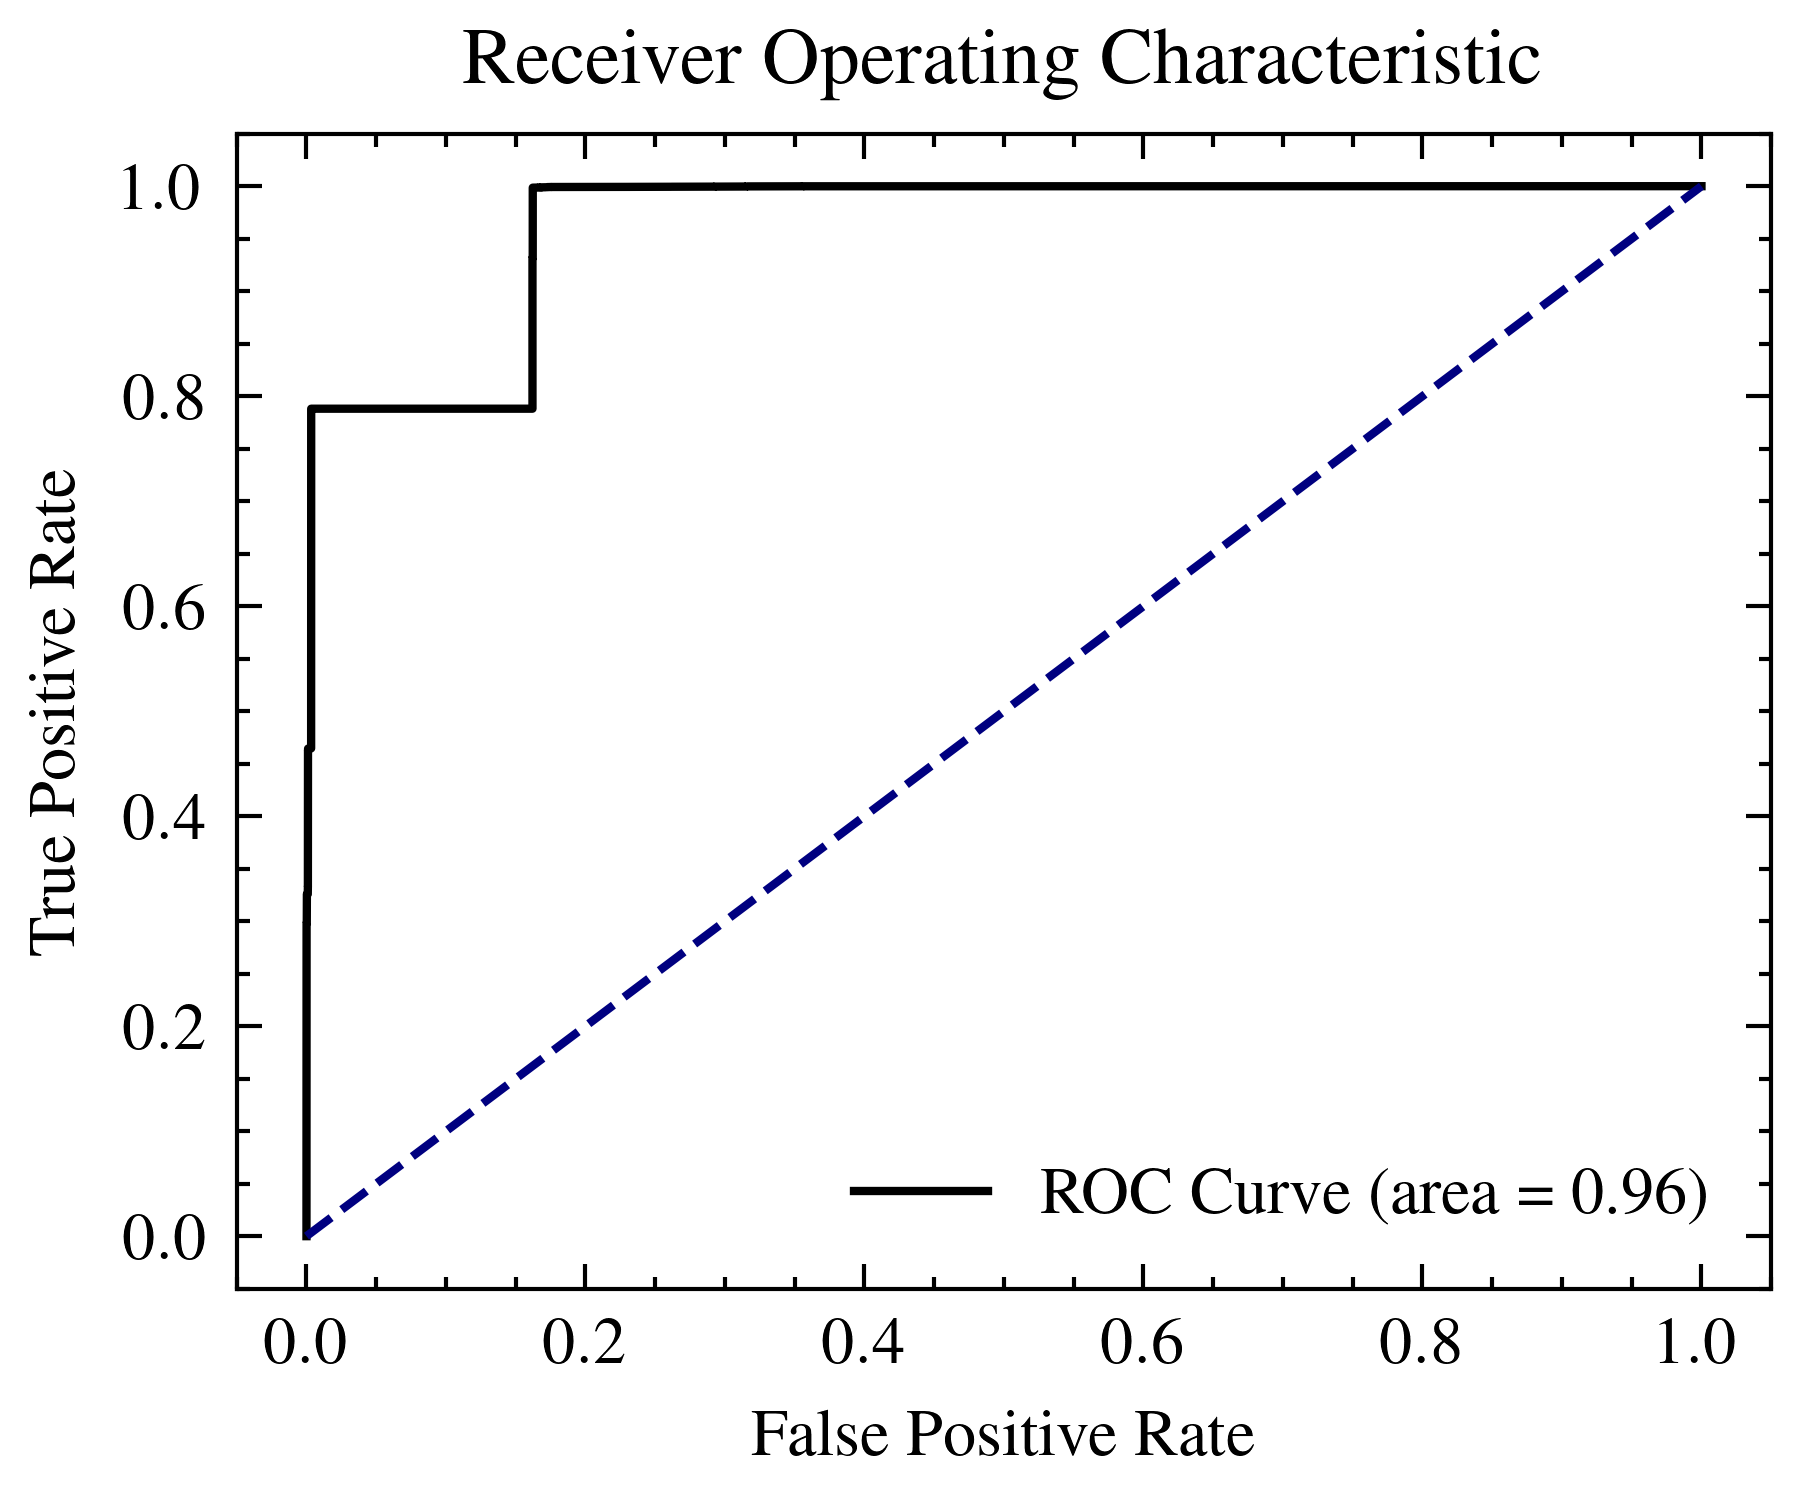

In [16]:
# predictions
predictions = model.predict(test_features)
predictions_prob = model.predict_proba(test_features)[:, 1]

# evaluate model
accuracy = metrics.accuracy_score(test_labels, predictions)
print(f"Train accuracy: {accuracy}\n")
conf_matrix = metrics.confusion_matrix(test_labels, predictions)
print(f"Confusion matrix:\n{conf_matrix}\n")
report = metrics.classification_report(test_labels, predictions)
print(f"Classification report:\n{report}")

# compute precision-recall curve and area
precision, recall, _ = metrics.precision_recall_curve(
    test_labels, predictions_prob
)
pr_auc = metrics.auc(recall, precision)
# plot precision-recall curve
plt.figure()
plt.plot(recall, precision, label=f"PR Curve (area = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.show()

# compute roc curve and area
fpr, tpr, _ = metrics.roc_curve(test_labels, predictions_prob)
roc_auc = metrics.auc(fpr, tpr)
# plot roc curve
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

# prepare feature names
tfidf_features = [
    "info_" + feature for feature in vectorizer.get_feature_names_out()
]
onehot_features = [
    "protocol_" + feature for feature in encoder.get_feature_names_out()
]
hashed_src_features = [f"hashed_src_{i}" for i in range(train_source.shape[1])]
hashed_dest_features = [f"hashed_dest_{i}" for i in range(train_dest.shape[1])]
# combine all feature names
all_feature_names = (
    list(tfidf_features)
    + list(onehot_features)
    + list(hashed_src_features)
    + list(hashed_dest_features)
    + ["Time", "Length"]
)
# ensure the number of names matches the number of features
assert len(all_feature_names) == train_features.shape[1]
